In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from adjustText import adjust_text
from sklearn.linear_model import LinearRegression
import seaborn.objects as so

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
final_results_path = "results/final"
experiment_config = ["backend", "model_type", "model_complexity", "precision", "seed"]
output_format = "pdf"

Before all, a dataframe with all experiments' configuration and CSV paths is defined, for easier data manipulation.

In [3]:
# Dictionary to store the data
rows = []
error_rows = []

# Iterate through the seed folders
for seed in os.listdir(final_results_path):
    seed_path = os.path.join(final_results_path, seed)
    
    # Check that it is a directory
    if os.path.isdir(seed_path):

        # Iterate through the model folders inside each seed
        for folder in os.listdir(seed_path):
            folder_path = os.path.join(seed_path, folder)

            if not os.path.isdir(folder_path):
                continue

            # Extract info from folder name
            # Precision can contain _, so a workaround is needed
            timestamp, backend, model, model_complexity, right = folder.split("_", 4)
            precision, _ = right.rsplit("_", 1) # precision, seed

            experiment_info = {
                "timestamp": timestamp,
                "backend": backend,
                "model_type": model,
                "model_complexity": model_complexity,
                "precision": precision,
                "seed": seed,
            }

            if "error.txt" in os.listdir(folder_path):
                error_rows.append({
                    **experiment_info,
                    "path": os.path.join(folder_path, "error.txt")
                })
                continue

            # Add csv files' info
            for file in os.listdir(folder_path):
                if file.endswith(".csv"):
                    rows.append({
                        **experiment_info,
                        "filename": os.path.splitext(file)[0],  # Name without extension
                        "path": os.path.join(folder_path, file)
                    })


index_df = pd.DataFrame(rows)
error_df = pd.DataFrame(error_rows)

In [4]:
index_df.head()

,timestamp,backend,model_type,model_complexity,precision,seed,filename,path
0,20250724-142036,torch,mlp,simple,fp32,42,train_samples,results/final/42/20250724-142036_torch_mlp_sim...
1,20250724-142036,torch,mlp,simple,fp32,42,test_samples,results/final/42/20250724-142036_torch_mlp_sim...
2,20250724-142036,torch,mlp,simple,fp32,42,global_metrics,results/final/42/20250724-142036_torch_mlp_sim...
3,20250724-142036,torch,mlp,simple,fp32,42,train,results/final/42/20250724-142036_torch_mlp_sim...
4,20250724-142036,torch,mlp,simple,fp32,42,test,results/final/42/20250724-142036_torch_mlp_sim...


In [5]:
error_df.head()

,timestamp,backend,model_type,model_complexity,precision,seed,path
0,20250728-145122,torch-keras,lstm,simple,fp16,42,results/final/42/20250728-145122_torch-keras_l...
1,20250729-134409,jax,lstm,simple,bf16,42,results/final/42/20250729-134409_jax_lstm_simp...
2,20250726-152014,tf-keras,lstm,simple,bf16,42,results/final/42/20250726-152014_tf-keras_lstm...
3,20250728-145247,torch-keras,lstm,simple,bf16,42,results/final/42/20250728-145247_torch-keras_l...
4,20250729-134358,jax,lstm,simple,fp16,42,results/final/42/20250729-134358_jax_lstm_simp...


## Statistical analysis ##

In [6]:
rows = []

for keys, subset_df in index_df.groupby(experiment_config):
    backend, model, model_complexity, precision, seed = keys

    row = {
        "backend": backend,
        "model_type": model,
        "model_complexity": model_complexity,
        "precision": precision,
        "seed": seed,
    }



    # --- Global metrics ---
    global_metrics_row = subset_df[subset_df["filename"] == "global_metrics"]
    global_metrics_df = pd.read_csv(global_metrics_row.iloc[0]["path"])
    global_metrics = global_metrics_df[["training_time", "testing_time"]].iloc[0]
    row.update(global_metrics.to_dict())



    # --- Train ---
    train_row = subset_df[subset_df["filename"] == "train"]
    train_df = pd.read_csv(train_row.iloc[0]["path"])

    # Metric can be accuracy or MAE
    try:
        metric_mean = train_df["accuracy"].mean()
        val_metric_mean = train_df["val_accuracy"].mean()
    except KeyError:
        metric_mean = train_df["mae"].mean()
        val_metric_mean = train_df["val_mae"].mean()

    row.update({
        "train_loss_mean": train_df["loss"].mean(),
        "train_metric_mean": metric_mean,
        "train_val_loss_mean": train_df["val_loss"].mean(),
        "train_val_metric_mean": val_metric_mean,
        "train_epoch_time_mean": train_df["epoch_time"].mean()
    })



    # --- Train samples ---
    train_samples_row = subset_df[subset_df["filename"] == "train_samples"]
    train_samples_df = pd.read_csv(train_samples_row.iloc[0]["path"])
    row.update({
        "train_gpu_utilization_mean": train_samples_df["gpu_2_utilization"].mean(),
        "train_gpu_memory_mean": train_samples_df["gpu_2_memory_used"].mean(),
        "train_gpu_power_mean": train_samples_df["gpu_2_power"].mean(),
    })



    # --- Test ---
    test_row = subset_df[subset_df["filename"] == "test"]
    test_df = pd.read_csv(test_row.iloc[0]["path"])

    try:
        metric_mean = train_df["accuracy"].mean()
    except KeyError:
        metric_mean = train_df["mae"].mean()

    row.update({
        "test_loss_mean": test_df["loss"].mean(),
        "test_metric_mean": metric_mean
    })



    # --- Test samples ---
    test_samples_row = subset_df[subset_df["filename"] == "test_samples"]
    test_samples_df = pd.read_csv(test_samples_row.iloc[0]["path"])
    row.update({
        "test_gpu_utilization_mean": test_samples_df["gpu_2_utilization"].mean(),
        "test_gpu_memory_mean": test_samples_df["gpu_2_memory_used"].mean(),
        "test_gpu_power_mean": test_samples_df["gpu_2_power"].mean(),
    })

    rows.append(row)

metrics_df = pd.DataFrame(rows)

In [7]:
metrics_df.head()

,backend,model_type,model_complexity,precision,seed,training_time,testing_time,train_loss_mean,train_metric_mean,train_val_loss_mean,train_val_metric_mean,train_epoch_time_mean,train_gpu_utilization_mean,train_gpu_memory_mean,train_gpu_power_mean,test_loss_mean,test_metric_mean,test_gpu_utilization_mean,test_gpu_memory_mean,test_gpu_power_mean
0,jax,cnn,complex,bf16,42,593.557829,3.350694,0.617344,0.785566,1.944375,0.503899,5.900471,69.073254,62093.040992,132.206995,1.250000,0.785566,0.0,62093.1875,70.851
1,jax,cnn,complex,bf16,43,588.882573,3.386329,0.618457,0.784676,1.949922,0.497729,5.857713,69.197935,62093.039479,135.142317,1.218750,0.784676,0.0,62093.1875,72.408
2,jax,cnn,complex,bf16,44,586.818991,3.384836,0.652031,0.773345,2.030781,0.479748,5.842003,69.240069,62093.038968,137.332161,1.382812,0.773345,0.0,62093.1875,75.155
3,jax,cnn,complex,fp16,42,610.762836,3.359147,NaN,0.099999,NaN,0.100078,6.076235,66.251656,62098.978891,123.973142,NaN,0.099999,0.0,62099.1875,70.059
4,jax,cnn,complex,fp16,43,606.743080,3.369644,NaN,0.100000,NaN,0.100018,6.035710,66.123539,62098.977149,124.766868,NaN,0.100000,0.0,62099.1875,69.939


In [8]:
metrics = metrics_df.columns[5:]
seed_variability = []

for metric in metrics:
    for (backend, model, model_complexity, precision), base_df in metrics_df.groupby(experiment_config[:-1]):
        values = base_df.sort_values("seed")[metric].values
        
        mean = np.mean(values)
        std = np.std(values)
        cv = std / mean if mean != 0 and pd.notna(mean) else 0
        consistent = cv < 0.1  # 10% maximum acceptable variation

        seed_variability.append({
            "backend": backend,
            "model_type": model,
            "model_complexity": model_complexity,
            "precision": precision,
            "metric": metric,
            "mean": mean,
            "std": std,
            "cv": cv,
            "consistent": consistent
        })

variability_df = pd.DataFrame(seed_variability)

In [9]:
variability_df.head()

,backend,model_type,model_complexity,precision,metric,mean,std,cv,consistent
0,jax,cnn,complex,bf16,training_time,589.753131,2.819147,0.004780,True
1,jax,cnn,complex,fp16,training_time,600.153922,12.271100,0.020447,True
2,jax,cnn,complex,fp32,training_time,604.010209,4.338946,0.007184,True
3,jax,cnn,complex,mixed_bf16,training_time,655.684403,21.230969,0.032380,True
4,jax,cnn,complex,mixed_fp16,training_time,639.842714,1.395464,0.002181,True


In [10]:
num_metrics = len(variability_df)
num_consistent = variability_df["consistent"].sum()
percent = (num_consistent / num_metrics) * 100
print(f"{percent:.2f}% of metrics are consistent between seeds ({num_consistent} out of {num_metrics})")

91.76% of metrics are consistent between seeds (1872 out of 2040)


In [11]:
inconsistent_df = variability_df[~variability_df["consistent"]]
inconsistent_df.head()

,backend,model_type,model_complexity,precision,metric,mean,std,cv,consistent
35,jax-keras,cnn,simple,mixed_fp16,training_time,234.699164,24.417500,0.104037,False
58,tf-keras,cnn,simple,fp16,training_time,141.424864,15.303753,0.108211,False
61,tf-keras,cnn,simple,mixed_fp16,training_time,163.126355,17.509885,0.107339,False
150,jax,lstm,simple,mixed_bf16,testing_time,2.802004,0.472777,0.168728,False
151,jax,lstm,simple,mixed_fp16,testing_time,2.776334,0.479126,0.172575,False


In [12]:
(
    inconsistent_df
    .groupby(["backend", "model_type", "model_complexity"])
    .size()
    .reset_index(name="n_inconsistent")
    .sort_values("n_inconsistent", ascending=False)
)

,backend,model_type,model_complexity,n_inconsistent
14,tf-keras,lstm,simple,13
26,torch-keras,lstm,simple,12
27,torch-keras,mlp,complex,11
9,jax-keras,mlp,complex,11
10,jax-keras,mlp,simple,11
7,jax-keras,lstm,complex,9
5,jax-keras,cnn,complex,9
16,tf-keras,mlp,simple,8
24,torch-keras,cnn,simple,8
12,tf-keras,cnn,simple,8


In [13]:
(
    inconsistent_df
    .groupby(["backend"])
    .size()
    .reset_index(name="n_inconsistent")
    .sort_values("n_inconsistent", ascending=False)
)

,backend,n_inconsistent
1,jax-keras,50
4,torch-keras,42
2,tf-keras,39
0,jax,19
3,torch,18


In [14]:
(
    variability_df
    .groupby(["backend"])["consistent"]
    .mean()
    .reset_index(name="%_consistent")
    .sort_values("%_consistent")
)

,backend,%_consistent
1,jax-keras,0.871795
4,torch-keras,0.892308
2,tf-keras,0.907143
0,jax,0.951282
3,torch,0.960000


In [15]:
(
    variability_df
    .groupby(["model_type"])["consistent"]
    .mean()
    .reset_index(name="%_consistent")
    .sort_values("%_consistent")
    .head(20)
)

,model_type,%_consistent
1,lstm,0.883333
2,mlp,0.921333
0,cnn,0.938667


In [16]:
(
    variability_df
    .groupby(["precision"])["consistent"]
    .mean()
    .reset_index(name="%_consistent")
    .sort_values("%_consistent")
    .head(20)
)

,precision,%_consistent
0,bf16,0.884848
1,fp16,0.905556
4,mixed_fp16,0.922222
3,mixed_bf16,0.924444
2,fp32,0.940000


# Results analysis

In [17]:
orders = {
    "model_type": ["mlp", "cnn", "lstm"],
    "backend": ["jax", "jax-keras", "tf-keras", "torch-keras", "torch"],
    "model_complexity": ["simple", "complex"],
    "precision": ["fp32", "fp16", "bf16", "mixed_fp16", "mixed_bf16"],
    "seed": ["42", "43", "44"],
}

labels = {
    "model_type": {m: m.upper() for m in orders["model_type"]},
    "backend": {
        "jax": "JAX",
        "jax-keras": "JAX-Keras",
        "tf-keras": "TF-Keras",
        "torch-keras": "Torch-Keras",
        "torch": "Torch",
    },
    "model_complexity": {
        "simple": "Simple",
        "complex": "Complex",
    },
    "precision": {
        "fp32": "FP32",
        "fp16": "FP16",
        "bf16": "BF16",
        "mixed_fp16": "Mixed (FP16)",
        "mixed_bf16": "Mixed (BF16)",
    },
    "seed": {s: s for s in orders["seed"]},
}

titles = {
    "model_type": "Model",
    "backend": "Framework",
    "model_complexity": "Version",
    "precision": "Precision",
    "seed": "Seed",
}

def add_labels(df, sufix="", *, orders=orders, labels=labels):
    df = df.copy()

    for col, order in orders.items():

        if col not in df.columns:
            continue

        label_dict = labels[col]

        df[f"{col}{sufix}"] = pd.Categorical(
            df[col].map(label_dict),
            categories=[label_dict[o] for o in order],
            ordered=True,
        )

    return df


In [18]:
def add_title(plot, title, adjust=0.85, fontsize="large"):
    plot.figure.suptitle(title, fontsize=fontsize)
    plot.figure.subplots_adjust(top=adjust)

## Execution time

In [19]:
time_df = metrics_df[experiment_config + ["training_time", "testing_time"]].copy()
time_df.head()

,backend,model_type,model_complexity,precision,seed,training_time,testing_time
0,jax,cnn,complex,bf16,42,593.557829,3.350694
1,jax,cnn,complex,bf16,43,588.882573,3.386329
2,jax,cnn,complex,bf16,44,586.818991,3.384836
3,jax,cnn,complex,fp16,42,610.762836,3.359147
4,jax,cnn,complex,fp16,43,606.743080,3.369644


In [20]:
def format_legend_title(plot, feature="precision", *, titles=titles):
    title = titles[feature]
    plot._legend.set_title(fr"$\bf{{ {title} }}$")

In [21]:
def save_plot(plot, name, format=output_format):
    img_path = f"img/{name}.{format}"

    try:
        plot.savefig(img_path, format=format)
    except:
        plt.savefig(img_path, format=format)

### Training time

In [22]:
add_labels(time_df).head()

,backend,model_type,model_complexity,precision,seed,training_time,testing_time
0,JAX,CNN,Complex,BF16,42,593.557829,3.350694
1,JAX,CNN,Complex,BF16,43,588.882573,3.386329
2,JAX,CNN,Complex,BF16,44,586.818991,3.384836
3,JAX,CNN,Complex,FP16,42,610.762836,3.359147
4,JAX,CNN,Complex,FP16,43,606.743080,3.369644


In [23]:
def plot_training_time(df, model, complexity, log=False):
    plot_df = df.query("model_type==@model and model_complexity==@complexity")
    plot_df = add_labels(plot_df)

    plot = sns.catplot(
        data=plot_df,
        x="backend",
        y="training_time",
        hue="precision",
        kind="bar",
        errorbar="sd"
    )

    model = labels["model_type"][model]
    complexity = labels["model_complexity"][complexity]

    # Title
    add_title(plot, f"{model} - {complexity} training time", adjust=0.95)
    plot.set_titles("{col_name}")

    if log:
        plot.set(yscale="log")
        plot.set_axis_labels(titles["backend"], "Training time (s, log)")
    else:
        plot.set_axis_labels(titles["backend"], "Training time (s)")
        
    format_legend_title(plot)
    #sns.move_legend(plot, "upper left", bbox_to_anchor=(0.08, 0.89), frameon=True)
    plot.tight_layout()

    save_plot(plot, f"training_time_{model}_{complexity}")

    return plot

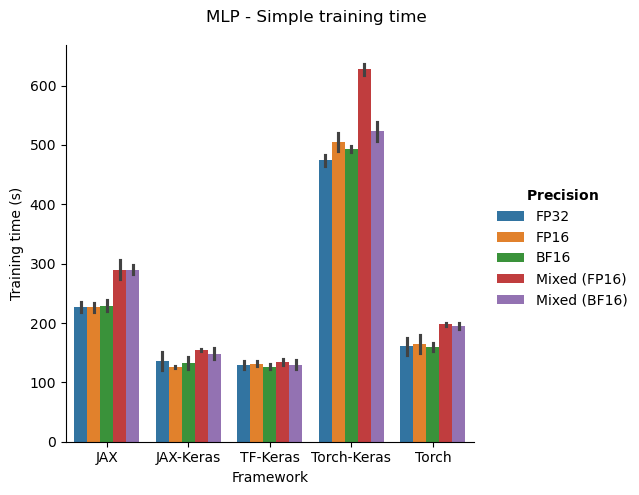

In [24]:
plot = plot_training_time(time_df, "mlp", "simple")

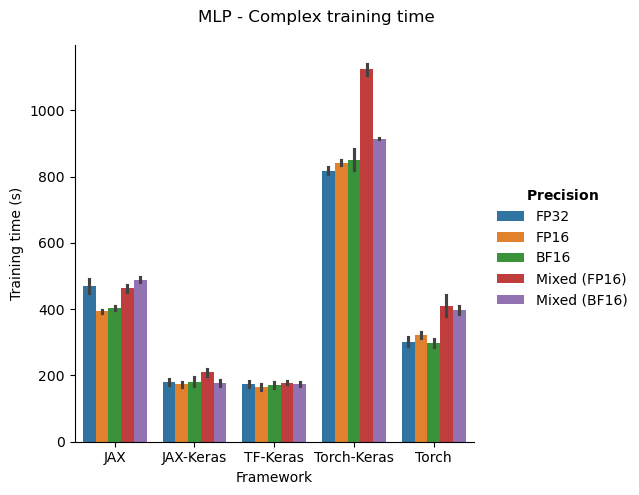

In [25]:
plot_training_time(time_df, "mlp", "complex")

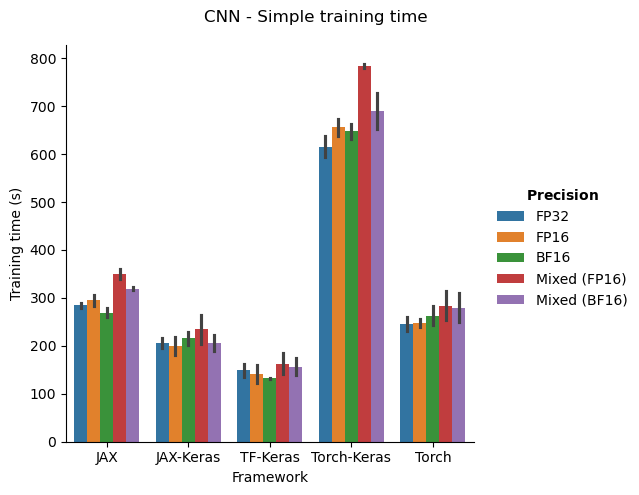

In [26]:
plot_training_time(time_df, "cnn", "simple")

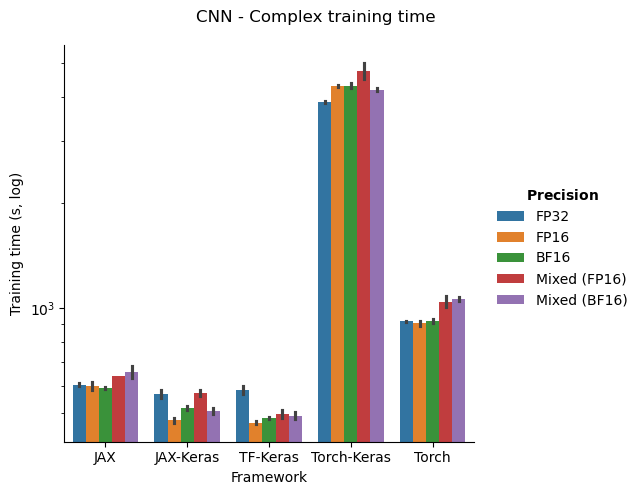

In [27]:
plot_training_time(time_df, "cnn", "complex", log=True)

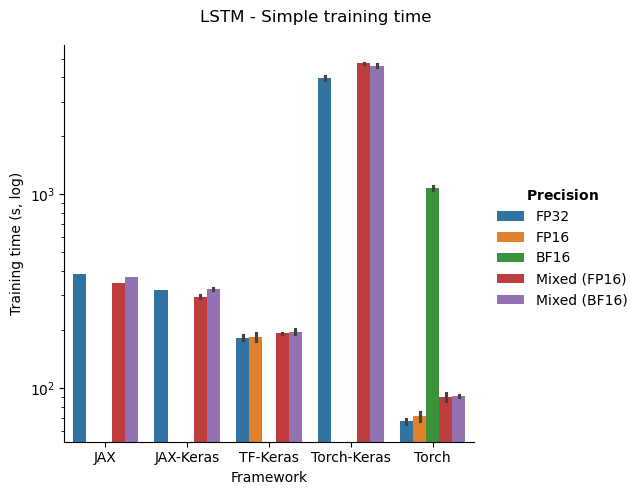

In [28]:
plot_training_time(time_df, "lstm", "simple", log=True)

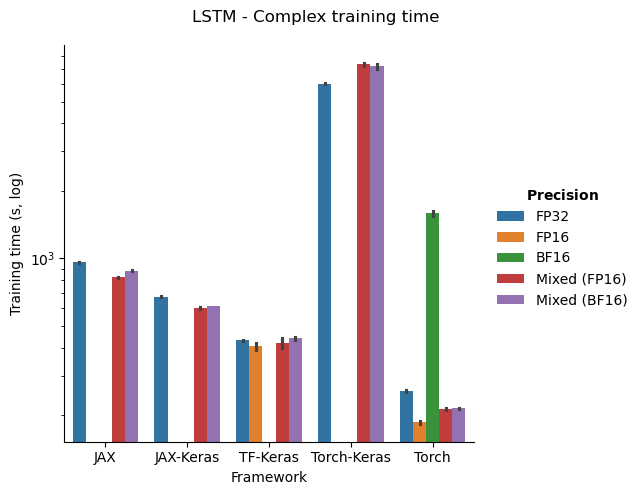

In [29]:
plot_training_time(time_df, "lstm", "complex", log=True)

In [30]:
time_df.head()

,backend,model_type,model_complexity,precision,seed,training_time,testing_time
0,jax,cnn,complex,bf16,42,593.557829,3.350694
1,jax,cnn,complex,bf16,43,588.882573,3.386329
2,jax,cnn,complex,bf16,44,586.818991,3.384836
3,jax,cnn,complex,fp16,42,610.762836,3.359147
4,jax,cnn,complex,fp16,43,606.743080,3.369644


In [31]:
base_df = time_df.query("model_type=='mlp' and model_complexity=='complex'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["training_time"]
    .median()
    .reset_index()
)
ref = base_df["training_time"].min()
base_df["training_time_comp"] = 1 - (base_df["training_time"] / ref)
base_df = base_df.sort_values(by="training_time", ascending=True)
base_df.head()

,backend,model_type,model_complexity,training_time,training_time_comp
2,tf-keras,mlp,complex,171.842384,0.000000
1,jax-keras,mlp,complex,180.874522,-0.052561
3,torch,mlp,complex,318.357171,-0.852611
0,jax,mlp,complex,455.801241,-1.652438
4,torch-keras,mlp,complex,867.926929,-4.050715


### Testing time

In [32]:
def plot_testing_time(df, model, complexity, log=False):
    plot_df = df.query("model_type==@model and model_complexity==@complexity")
    plot_df = add_labels(plot_df)

    plot = sns.catplot(
        data=plot_df,
        x="backend",
        y="testing_time",
        hue="precision",
        kind="bar",
        errorbar="sd"
    )

    model = labels["model_type"][model]
    complexity = labels["model_complexity"][complexity]

    # Title
    add_title(plot, f"{model} - {complexity} testing time", adjust=0.95)
    plot.set_titles("{col_name}")

    if log:
        plot.set(yscale="log")
        plot.set_axis_labels(titles["backend"], "Testing time (s, log)")
    else:
        plot.set_axis_labels(titles["backend"], "Testing time (s)")
        
    format_legend_title(plot)
    #sns.move_legend(plot, "upper left", bbox_to_anchor=(0.08, 0.89), frameon=True)
    plot.tight_layout()

    save_plot(plot, f"testing_time{model}_{complexity}")

    return plot

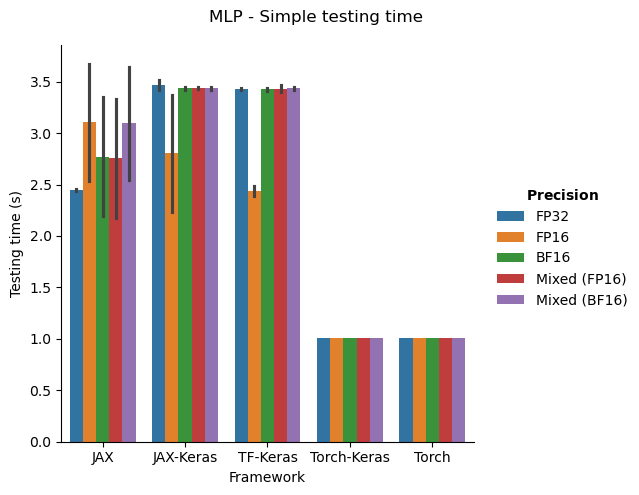

In [33]:
plot_testing_time(time_df, "mlp", "simple")

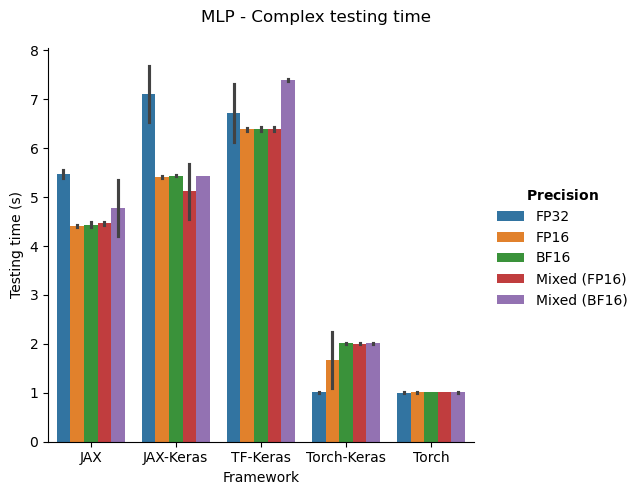

In [34]:
plot_testing_time(time_df, "mlp", "complex")

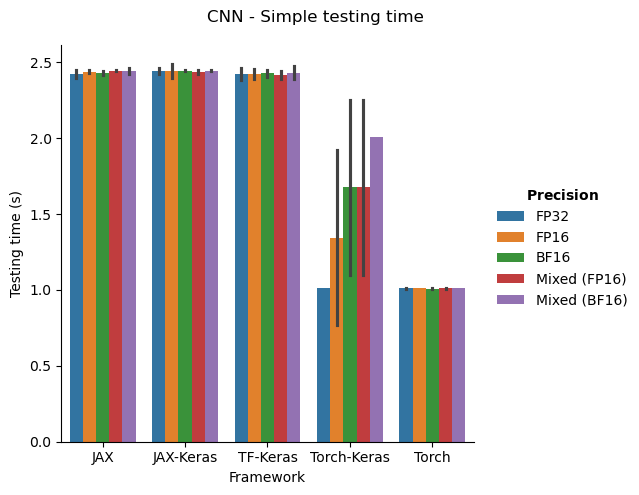

In [35]:
plot_testing_time(time_df, "cnn", "simple")

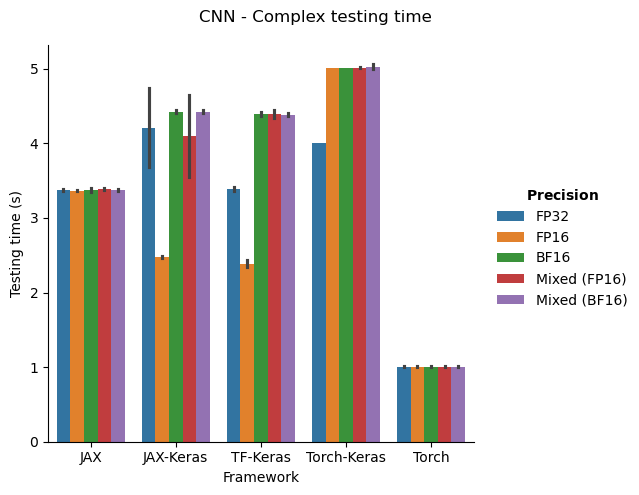

In [36]:
plot_testing_time(time_df, "cnn", "complex")

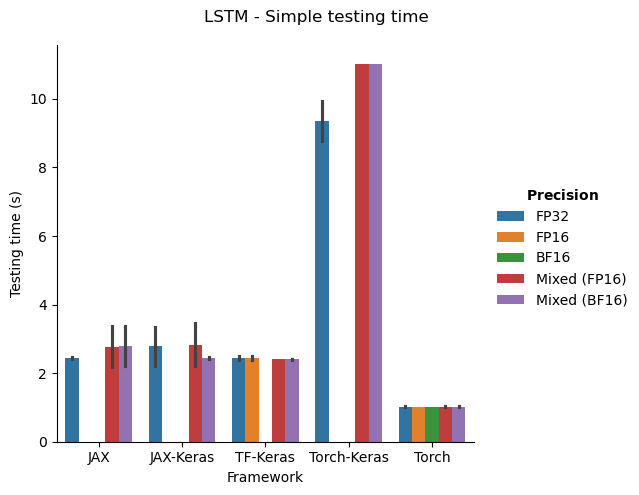

In [37]:
plot_testing_time(time_df, "lstm", "simple")

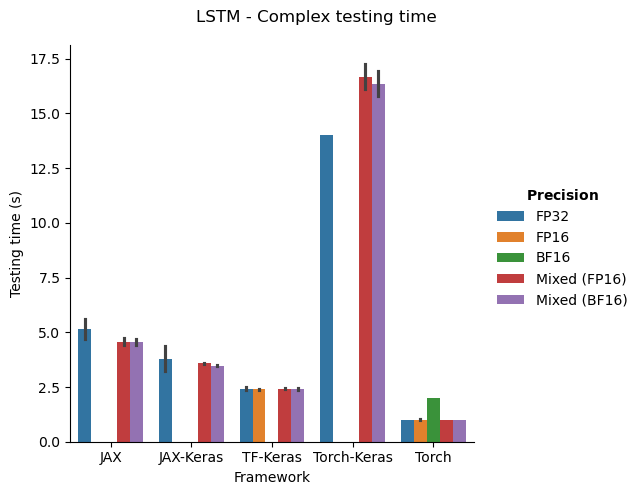

In [38]:
plot_testing_time(time_df, "lstm", "complex")

In [39]:
base_df = time_df.query("model_type=='mlp' and model_complexity=='complex'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["testing_time"]
    .median()
    .reset_index()
)
ref = base_df["testing_time"].min()
base_df["testing_time_comp"] = (1 - (base_df["testing_time"] / ref))
base_df = base_df.sort_values(by="testing_time", ascending=True)
base_df.head()

,backend,model_type,model_complexity,testing_time,testing_time_comp
3,torch,mlp,complex,1.007332,0.000000
4,torch-keras,mlp,complex,2.007081,-0.992472
0,jax,mlp,complex,4.460454,-3.427987
1,jax-keras,mlp,complex,5.434900,-4.395340
2,tf-keras,mlp,complex,6.407153,-5.360515


## GPU metrics

In [40]:
def exp_config_category(df):
    # Convert experiment config columns to categorical, for better performance
    for col in experiment_config:
        order = orders[col]
        df[col] = pd.Categorical(
            df[col],
            categories=order,
            ordered=True
        )
    
    return df

In [41]:
df_list = []

for keys, subset_df in index_df[index_df["filename"] == "train_samples"].groupby(experiment_config):
    backend, model, model_complexity, precision, seed = keys

    base_df = pd.read_csv(subset_df.iloc[0]["path"])

    base_df["backend"] = backend
    base_df["model_type"] = model
    base_df["model_complexity"] = model_complexity
    base_df["precision"] = precision
    base_df["seed"] = seed

    df_list.append(base_df)

train_samples_df = pd.concat(df_list, ignore_index=True)

# Reorder, add categories and sort by timestamp
train_samples_df = train_samples_df[experiment_config + train_samples_df.columns[:4].to_list()]
train_samples_df = exp_config_category(train_samples_df)
train_samples_df = train_samples_df.sort_values(by=experiment_config).reset_index(drop=True)

train_samples_df.head()

,backend,model_type,model_complexity,precision,seed,timestamp,gpu_2_utilization,gpu_2_memory_used,gpu_2_power
0,jax,mlp,simple,fp32,42,2.190392,0,62065.1875,64.923
1,jax,mlp,simple,fp32,42,3.191456,0,62075.1875,63.950
2,jax,mlp,simple,fp32,42,4.192263,9,62075.1875,65.681
3,jax,mlp,simple,fp32,42,5.193223,0,62075.1875,64.644
4,jax,mlp,simple,fp32,42,6.194193,0,62075.1875,64.436


### GPU utilisation

In [ ]:
def plot_utilisation_time(df, model, complexity, log=False):
    plot_df = df.query("model_type==@model and model_complexity==@complexity")
    plot_df = add_labels(plot_df)

    plot = sns.catplot(
        data=plot_df,
        x="backend",
        y="gpu_2_utilization",
        hue="precision",
        kind="bar",
        errorbar="sd"
    )

    model = labels["model_type"][model]
    complexity = labels["model_complexity"][complexity]

    # Title
    add_title(plot, f"{model} - {complexity} mean GPU utilisation", adjust=0.95)
    plot.set_titles("{col_name}")

    if log:
        plot.set(yscale="log")
        plot.set_axis_labels(titles["backend"], "GPU Utilisation (%, log)")
    else:
        plot.set_axis_labels(titles["backend"], "GPU Utilisation (%)")
        
    format_legend_title(plot)
    #sns.move_legend(plot, "upper left", bbox_to_anchor=(0.08, 0.89), frameon=True)
    plot.tight_layout()

    #save_plot(plot, f"utilisation_bars_{model}_{complexity}")

    return plot

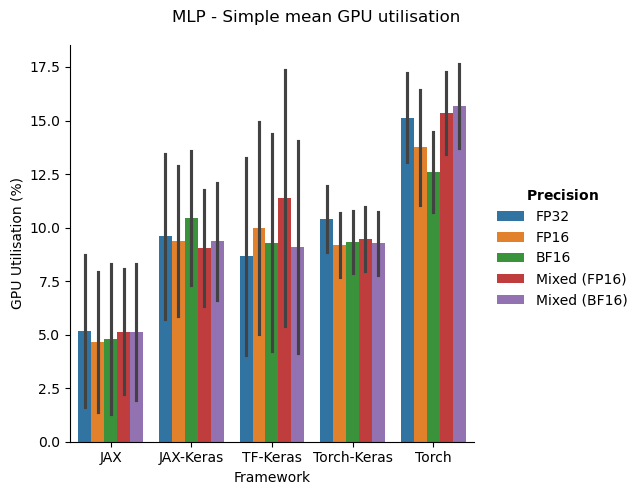

In [43]:
plot_utilisation_time(train_samples_df, "mlp", "simple")

In [44]:
def plot_utilisation_heatmap(df, model, complexity):
    plot_df = df.query("model_type==@model and model_complexity==@complexity")
    plot_df = plot_df.groupby(experiment_config[:-1])["gpu_2_utilization"].mean().reset_index()
    plot_df = add_labels(plot_df)

    plot_df = plot_df.pivot_table(
        index="precision", columns="backend", values="gpu_2_utilization"
    )

    plot = sns.heatmap(
        plot_df,
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        cbar_kws={"label": "GPU usage (%)"}
    )
    
    model = labels["model_type"][model]
    complexity = labels["model_complexity"][complexity]

    add_title(plot, f"{model} - {complexity} mean GPU usage", adjust=0.92)
    plot.set_xlabel(titles["backend"])
    plot.set_ylabel(titles["precision"])

    save_plot(plot, f"usage_heatmap_{model}_{complexity}")

    return plot

/tmp/ipykernel_4024815/874083804.py:3: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plot.figure.subplots_adjust(top=adjust)
/tmp/ipykernel_4024815/874083804.py:3: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plot.figure.subplots_adjust(top=adjust)
/tmp/ipykernel_4024815/874083804.py:3: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plot.figure.subplots_adjust(top=adjust)
/tmp/ipykernel_4024815/874083804.py:3: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plot.figure.subplots_adjust(top=adjust)
/tmp/ipykernel_4024815/874083804.py:3: UserWarning: This figure was using a layout engine that is incomp

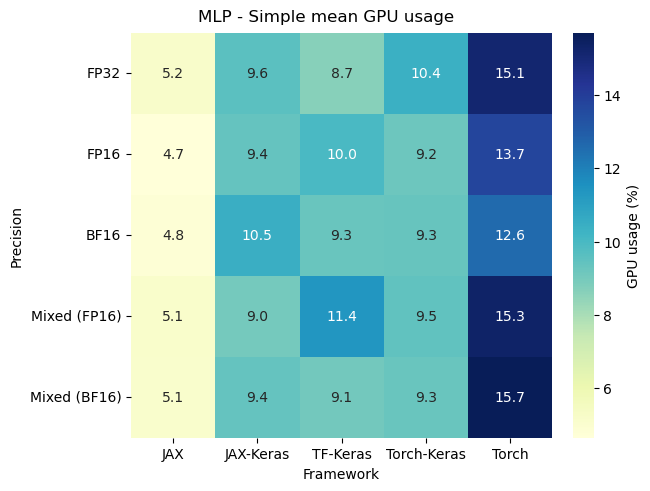

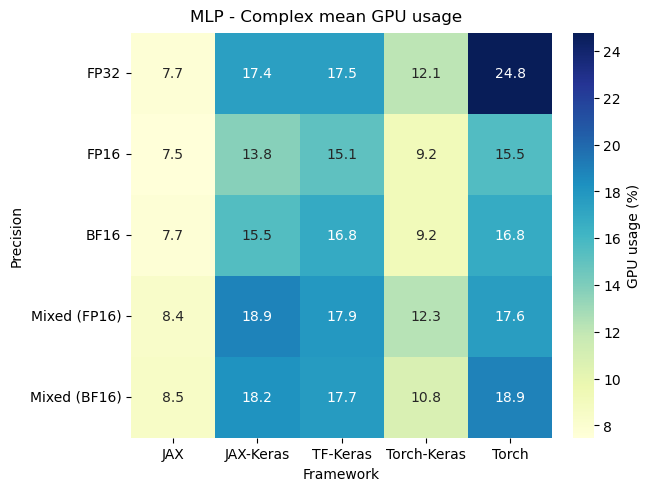

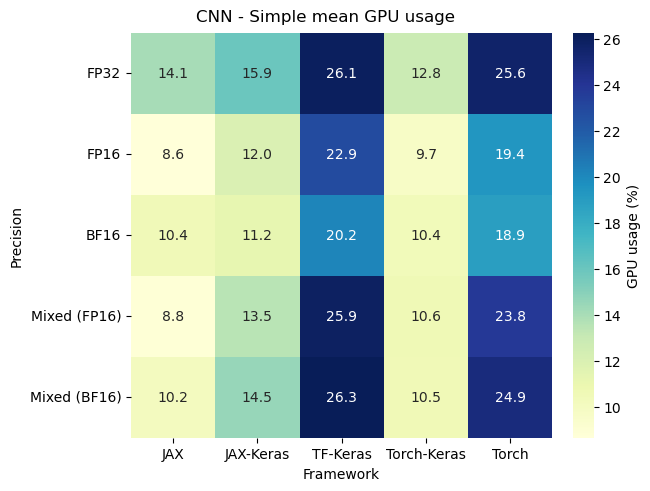

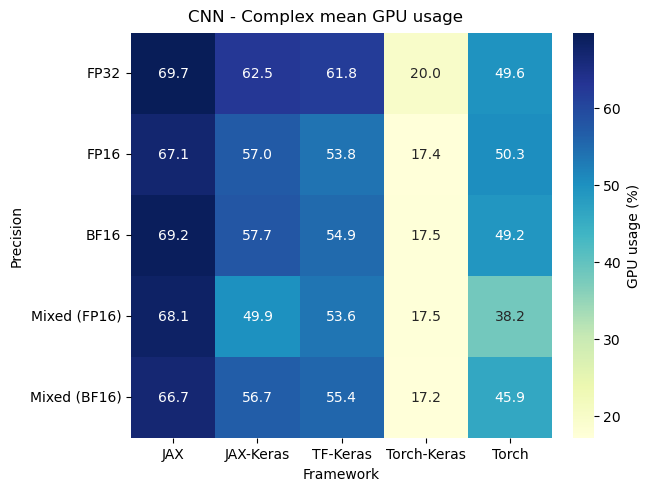

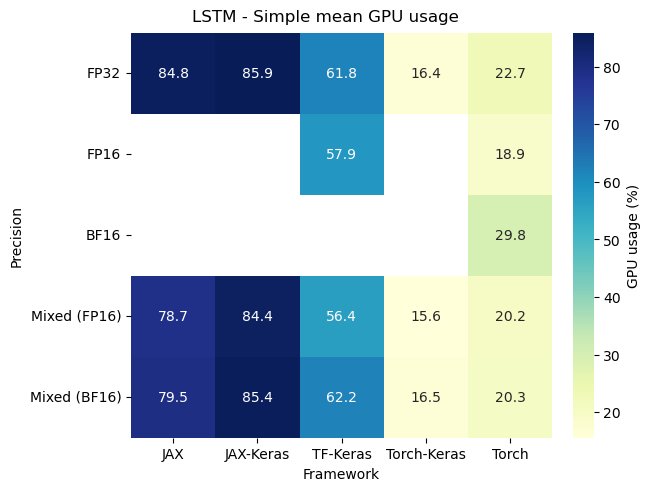

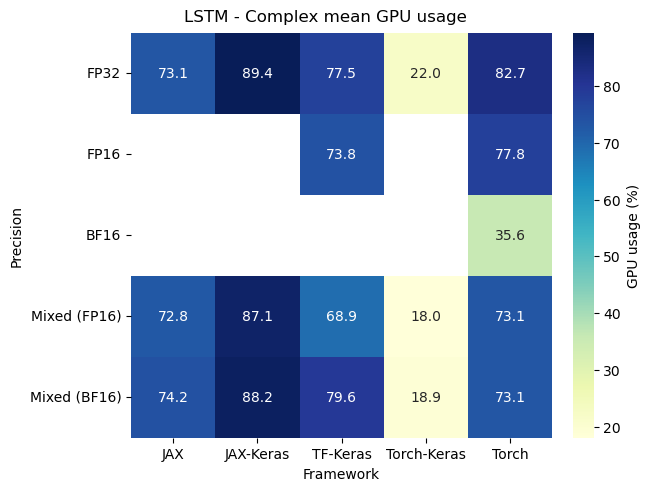

In [198]:
for model in orders["model_type"]:
    for complexity in orders["model_complexity"]:
        plt.figure(constrained_layout=True)
        plot = plot_utilisation_heatmap(train_samples_df, model, complexity)

In [46]:
base_df = train_samples_df.query("model_type=='mlp' and model_complexity=='complex'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["gpu_2_utilization"]
    .mean()
    .reset_index()
)
base_df = base_df.sort_values(by="gpu_2_utilization", ascending=True)
base_df.head()

,backend,model_type,model_complexity,gpu_2_utilization
1,jax,mlp,complex,7.995294
19,torch-keras,mlp,complex,10.809010
7,jax-keras,mlp,complex,16.824568
13,tf-keras,mlp,complex,17.025118
25,torch,mlp,complex,18.631944


### GPU memory

In [47]:
memory_df = train_samples_df.groupby(experiment_config[:-1])["gpu_2_memory_used"].max().reset_index()
memory_df["max_memory"] = memory_df["gpu_2_memory_used"] / 1024  # Convert to GB
memory_df = memory_df.drop("gpu_2_memory_used", axis=1)
memory_df.head(10)

,backend,model_type,model_complexity,precision,max_memory
0,jax,mlp,simple,fp32,60.622253
1,jax,mlp,simple,fp16,60.630066
2,jax,mlp,simple,bf16,60.630066
3,jax,mlp,simple,mixed_fp16,60.630066
4,jax,mlp,simple,mixed_bf16,60.630066
5,jax,mlp,complex,fp32,60.622253
6,jax,mlp,complex,fp16,60.632019
7,jax,mlp,complex,bf16,60.632019
8,jax,mlp,complex,mixed_fp16,60.632019
9,jax,mlp,complex,mixed_bf16,60.632019


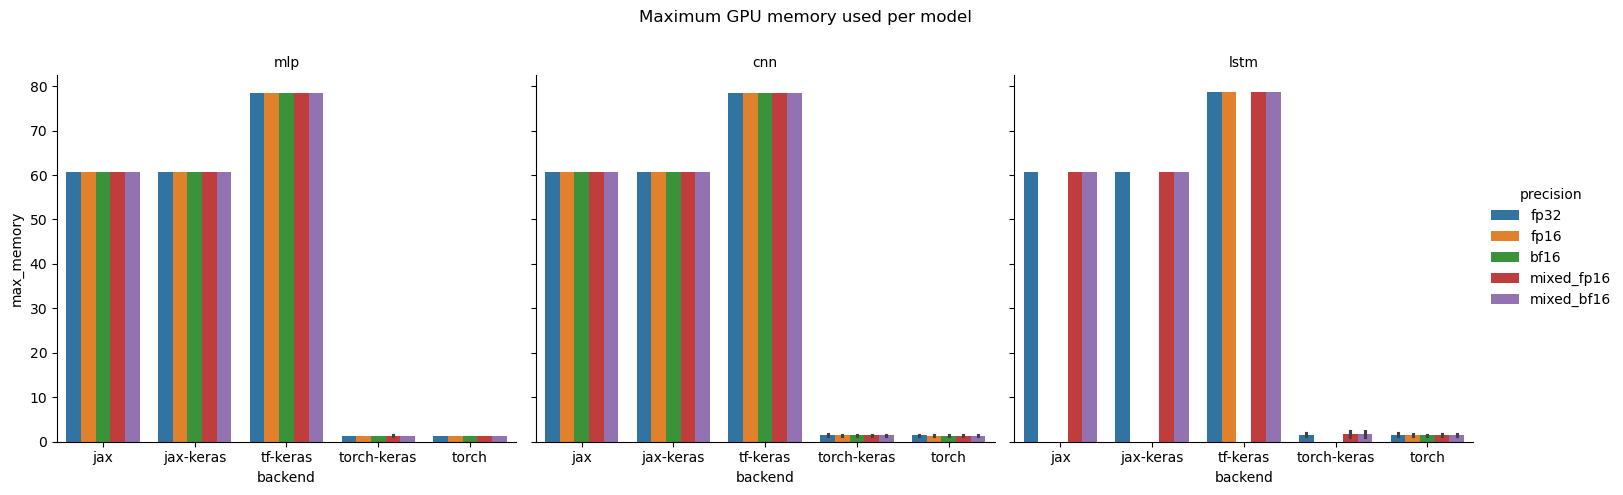

In [48]:
plot = sns.catplot(
    data=memory_df,
    x="backend",
    y="max_memory",
    hue="precision",
    col="model_type",
    kind="bar",
    errorbar="sd"
)

add_title(plot, "Maximum GPU memory used per model")

plot.set_titles(col_template="{col_name}")

In [49]:
memory_df = memory_df.groupby(["backend"])["max_memory"].max().sort_values(ascending=False).reset_index()
memory_df.head()

,backend,max_memory
0,tf-keras,78.569519
1,jax-keras,60.716003
2,jax,60.712097
3,torch-keras,2.216003
4,torch,1.815613


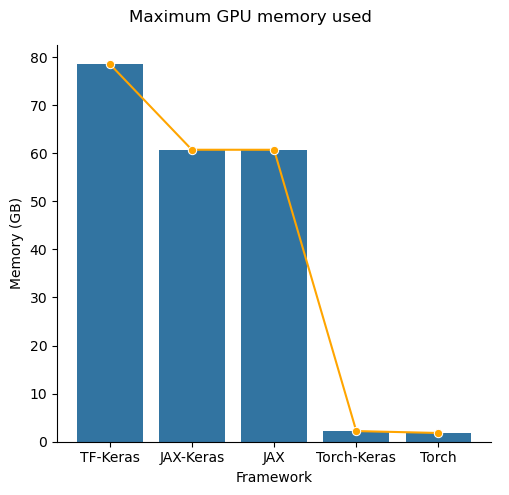

In [50]:
base_df = add_labels(memory_df)

plot = sns.catplot(
    data=base_df,
    x="backend",
    y="max_memory",
    kind="bar",
    errorbar="sd",
    order=base_df["backend"]
)

sns.lineplot(
    x=base_df["backend"],
    y=base_df["max_memory"],
    ax=plot.ax,
    marker="o",
    color="orange"
)

add_title(plot, "Maximum GPU memory used")
plot.set_axis_labels(titles["backend"], "Memory (GB)")

plt.tight_layout()

save_plot(plot, "memory_bars")

### GPU Power

In [51]:
energy_df = train_samples_df[experiment_config + ["timestamp", "gpu_2_power"]]

energy_df = energy_df.sort_values(by=experiment_config + ["timestamp"]).reset_index(drop=True)
energy_df.head()

,backend,model_type,model_complexity,precision,seed,timestamp,gpu_2_power
0,jax,mlp,simple,fp32,42,2.190392,64.923
1,jax,mlp,simple,fp32,42,3.191456,63.950
2,jax,mlp,simple,fp32,42,4.192263,65.681
3,jax,mlp,simple,fp32,42,5.193223,64.644
4,jax,mlp,simple,fp32,42,6.194193,64.436


### GPU Energy Consumption

In [52]:
# Energy (J) = Power (W) * time (s)
energy_df["dt"] = energy_df.groupby(experiment_config)["timestamp"].diff().fillna(0)

energy_df["energy"] = energy_df["gpu_2_power"] * energy_df["dt"]
energy_df["cum_energy"] = energy_df.groupby(experiment_config)["energy"].cumsum()

energy_df.head()

,backend,model_type,model_complexity,precision,seed,timestamp,gpu_2_power,dt,energy,cum_energy
0,jax,mlp,simple,fp32,42,2.190392,64.923,0.000000,0.000000,0.000000
1,jax,mlp,simple,fp32,42,3.191456,63.950,1.001064,64.018032,64.018032
2,jax,mlp,simple,fp32,42,4.192263,65.681,1.000807,65.734008,129.752039
3,jax,mlp,simple,fp32,42,5.193223,64.644,1.000959,64.706019,194.458058
4,jax,mlp,simple,fp32,42,6.194193,64.436,1.000970,64.498511,258.956569


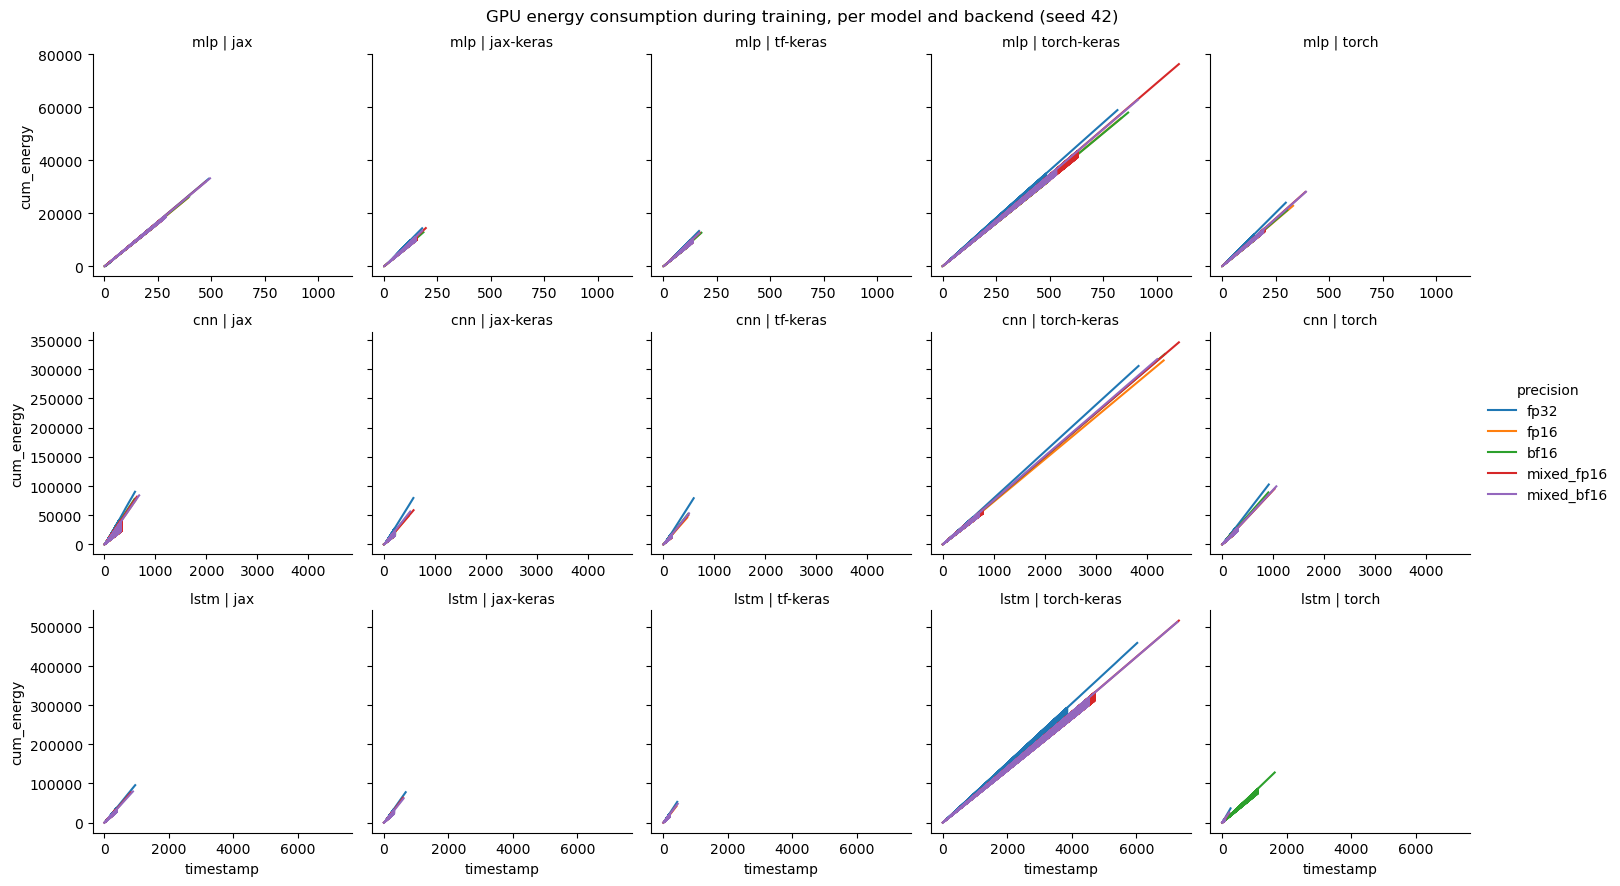

In [53]:
plot = sns.relplot(
    data=energy_df.query("seed == '42'"),
    x="timestamp",
    y="cum_energy",
    kind="line",
    hue="precision",
    col="backend",
    row="model_type",
    facet_kws={"sharey": "row", "sharex": "row"},
    height=3
)

add_title(plot, "GPU energy consumption during training, per model and backend (seed 42)", adjust=0.93)

plot.set_titles(row_template="{row_name}", col_template="{col_name}")


In [54]:

total_energy_df = (
    energy_df
    .groupby(experiment_config)["cum_energy"]
    .last()
    .reset_index()
    .rename(columns={"cum_energy": "energy"})
)

total_energy_df["energy"] = total_energy_df["energy"] / 1000 # kJ

total_energy_df.head()

,backend,model_type,model_complexity,precision,seed,energy
0,jax,mlp,simple,fp32,42,13.898514
1,jax,mlp,simple,fp32,43,15.192393
2,jax,mlp,simple,fp32,44,14.993291
3,jax,mlp,simple,fp16,42,13.783159
4,jax,mlp,simple,fp16,43,14.588840


In [55]:
def plot_total_energy(df, model, complexity, log=False):
    plot_df = df.query("model_type==@model and model_complexity==@complexity")
    plot_df = add_labels(plot_df)

    plot = sns.catplot(
        data=plot_df,
        x="backend",
        y="energy",
        hue="precision",
        kind="bar",
        errorbar="sd"
    )
    
    model = labels["model_type"][model]
    complexity = labels["model_complexity"][complexity]

    add_title(plot, f"{model} - {complexity} total energy consumption during training")
    format_legend_title(plot)

    if log:
        plot.set(yscale="log")
        plot.set_axis_labels(titles["backend"], "Energy (kJ, log)")
    else:
        plot.set_axis_labels(titles["backend"], "Energy (kJ)")

    save_plot(plot, f"total_energy_bars_{model}_{complexity}")

<Figure size 640x480 with 0 Axes>

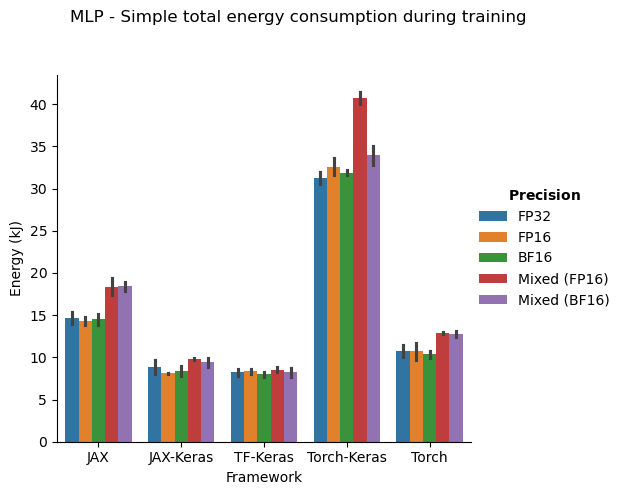

<Figure size 640x480 with 0 Axes>

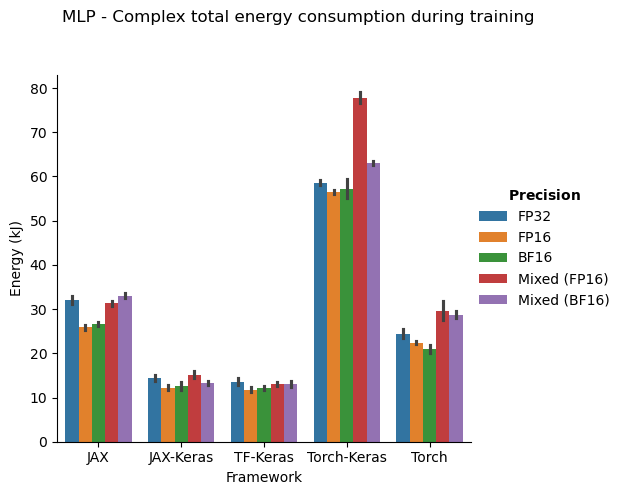

<Figure size 640x480 with 0 Axes>

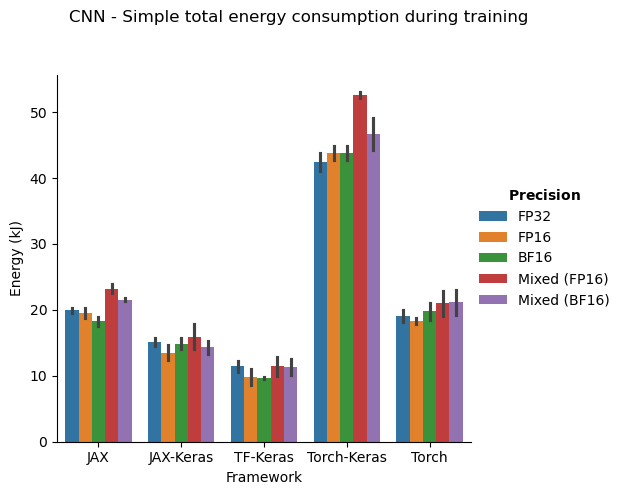

<Figure size 640x480 with 0 Axes>

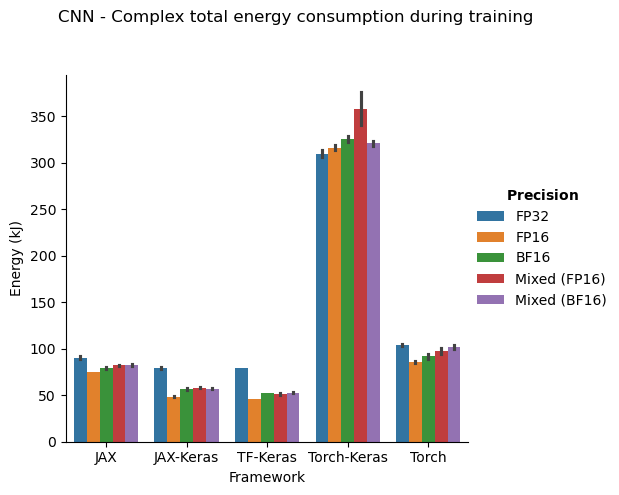

<Figure size 640x480 with 0 Axes>

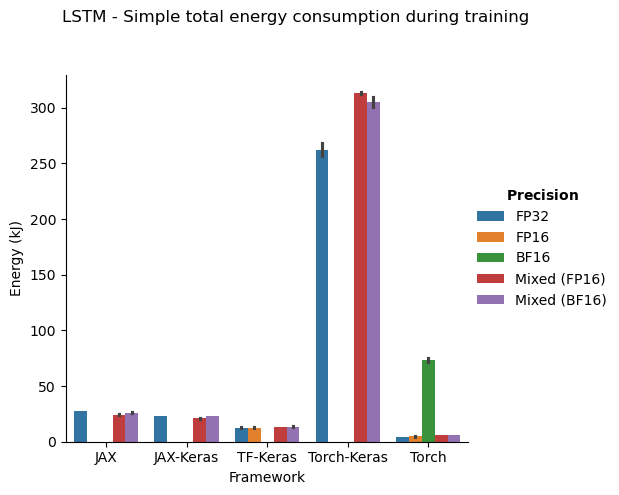

<Figure size 640x480 with 0 Axes>

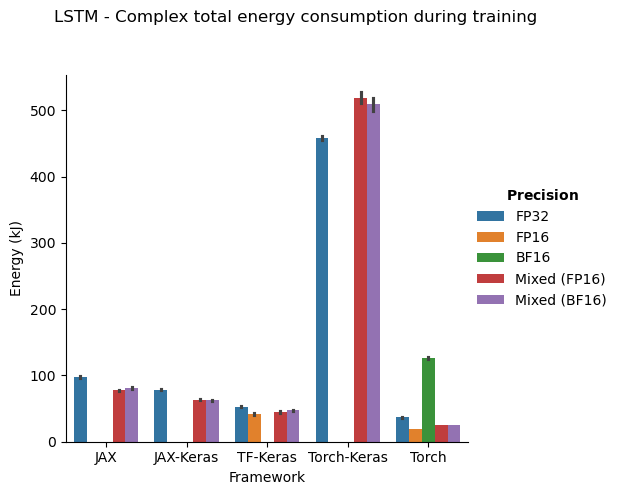

In [56]:
for model in orders["model_type"]:
    for complexity in orders["model_complexity"]:
        plt.figure()
        plot_total_energy(total_energy_df, model, complexity)

In [57]:
base_df = total_energy_df.query("model_type=='mlp' and model_complexity=='complex'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["energy"]
    .median()
    .reset_index()
)
ref = base_df["energy"].min()
base_df["energy_comp"] = 1 - (base_df["energy"] / ref)
base_df = base_df.sort_values(by="energy", ascending=True)
base_df.head()

,backend,model_type,model_complexity,energy,energy_comp
13,tf-keras,mlp,complex,12.660985,0.000000
7,jax-keras,mlp,complex,13.388892,-0.057492
25,torch,mlp,complex,23.978904,-0.893921
1,jax,mlp,complex,31.216973,-1.465604
19,torch-keras,mlp,complex,58.841989,-3.647505


In [58]:
base_df = total_energy_df.copy()
base_df["mixed"] = base_df["precision"].str.contains("mixed")
base_df = base_df[base_df["energy"] > 0]
base_df = (
    base_df.groupby(experiment_config[:-2] + ["mixed"])["energy"]
    .median()
    .reset_index()
)
base_df = base_df.pivot_table(
    index=experiment_config[:-2], 
    columns="mixed", 
    values="energy"
).reset_index()

base_df = base_df.rename(columns={False: "energy_no_mixed", True: "energy_mixed"})
base_df["comp"] = base_df["energy_mixed"] / base_df["energy_no_mixed"]

print(f"Result: {(base_df['comp'].median() - 1) * 100}")

Result: 8.94495081718427


### GPU Energy per Hour

In [59]:
time_df = exp_config_category(time_df)
time_df.head()

,backend,model_type,model_complexity,precision,seed,training_time,testing_time
0,jax,cnn,complex,bf16,42,593.557829,3.350694
1,jax,cnn,complex,bf16,43,588.882573,3.386329
2,jax,cnn,complex,bf16,44,586.818991,3.384836
3,jax,cnn,complex,fp16,42,610.762836,3.359147
4,jax,cnn,complex,fp16,43,606.743080,3.369644


In [60]:
total_energy_df = pd.merge(
    total_energy_df,
    time_df[experiment_config + ["training_time"]],
    on=experiment_config,
    how="left"
)

total_energy_df["energy_per_hour"] = total_energy_df["energy"] / (total_energy_df["training_time"] / 3600)

total_energy_df.head()

,backend,model_type,model_complexity,precision,seed,energy,training_time,energy_per_hour
0,jax,mlp,simple,fp32,42,13.898514,218.031574,229.483503
1,jax,mlp,simple,fp32,43,15.192393,234.050772,233.678420
2,jax,mlp,simple,fp32,44,14.993291,229.041067,235.660130
3,jax,mlp,simple,fp16,42,13.783159,217.017115,228.642664
4,jax,mlp,simple,fp16,43,14.588840,231.114597,227.245804


In [61]:
def plot_energy_hour(df, model, complexity, log=False):
    plot_df = df.query("model_type==@model and model_complexity==@complexity")
    plot_df = add_labels(plot_df)

    plot = sns.catplot(
        data=plot_df,
        x="backend",
        y="energy_per_hour",
        hue="precision",
        kind="bar",
        errorbar="sd"
    )

    model = labels["model_type"][model]
    complexity = labels["model_complexity"][complexity]

    add_title(plot, f"{model} - {complexity} energy consumption per training hour", 0.92)
    format_legend_title(plot)
    plot.set_axis_labels(titles["backend"], "Energy per hour (kJ/h)")
    
    if log:
        plot.set(yscale="log")
        plot.set_axis_labels(titles["backend"], "Energy per hour (kJ/h, log)")
    else:
        plot.set_axis_labels(titles["backend"], "Energy per hour (kJ/h)")

    save_plot(plot, f"energy_per_hour_bars_{model}_{complexity}")

<Figure size 640x480 with 0 Axes>

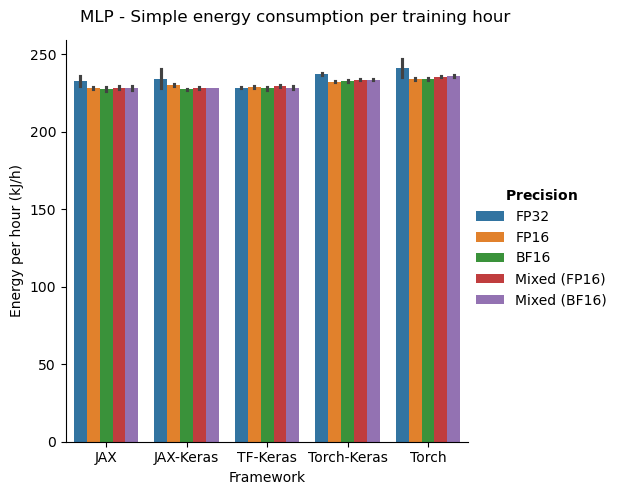

<Figure size 640x480 with 0 Axes>

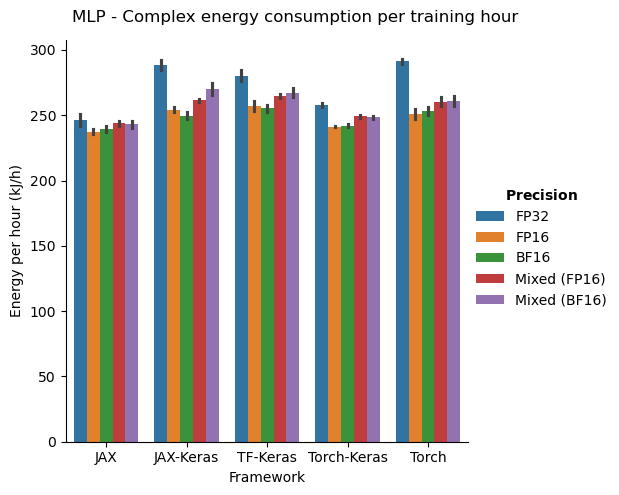

<Figure size 640x480 with 0 Axes>

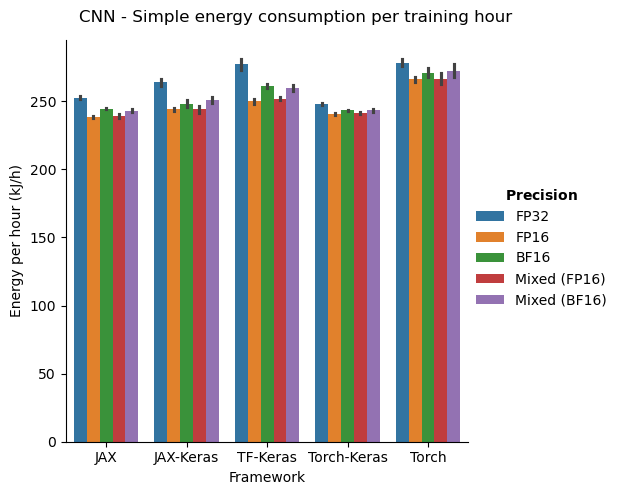

<Figure size 640x480 with 0 Axes>

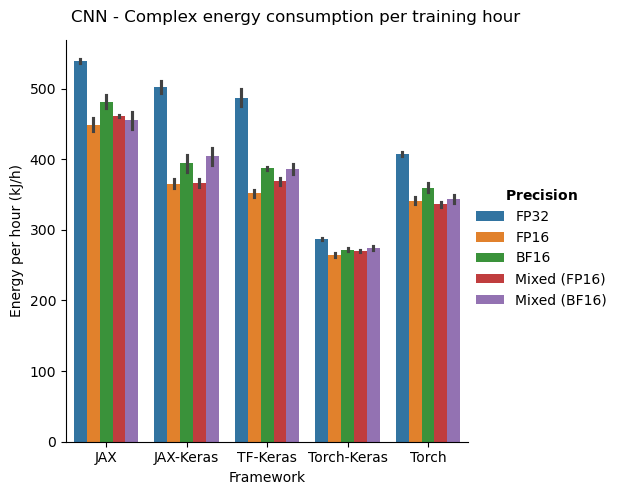

<Figure size 640x480 with 0 Axes>

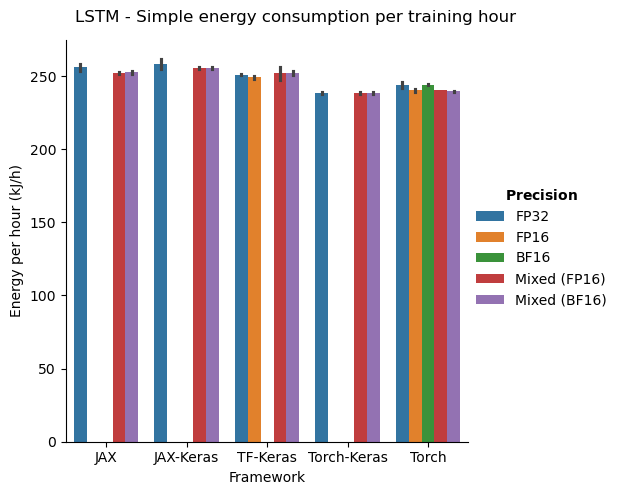

<Figure size 640x480 with 0 Axes>

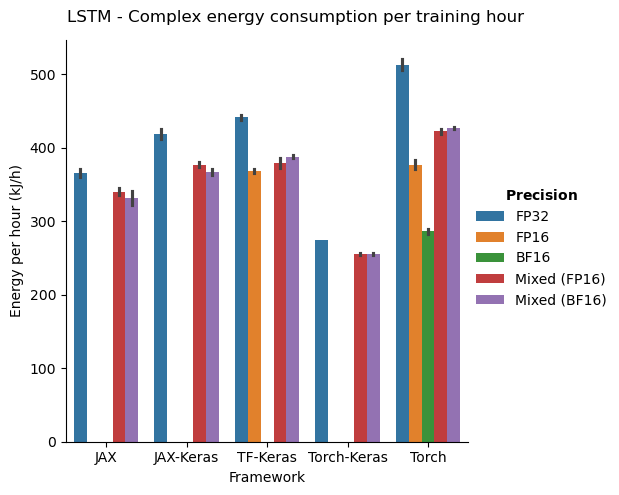

In [62]:
for model in orders["model_type"]:
    for complexity in orders["model_complexity"]:
        plt.figure()
        plot_energy_hour(total_energy_df, model, complexity)

In [63]:
base_df = total_energy_df.query("model_type=='mlp' and model_complexity=='complex'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["energy_per_hour"]
    .median()
    .reset_index()
)
ref = base_df["energy_per_hour"].min()
base_df["energy_comp"] = 1 - (base_df["energy_per_hour"] / ref)
base_df = base_df.sort_values(by="energy_per_hour", ascending=True)
base_df.head()

,backend,model_type,model_complexity,energy_per_hour,energy_comp
1,jax,mlp,complex,241.841756,0.000000
19,torch-keras,mlp,complex,247.983303,-0.025395
25,torch,mlp,complex,257.942294,-0.066575
7,jax-keras,mlp,complex,261.707926,-0.082145
13,tf-keras,mlp,complex,265.086070,-0.096114


In [64]:
base_df = total_energy_df.query("model_type=='mlp' and model_complexity=='complex'").copy()
base_df = (
    base_df.groupby(experiment_config[1:-1])["energy_per_hour"]
    .median()
    .reset_index()
)
ref = base_df["energy_per_hour"].min()
base_df["energy_comp"] = 1 - (base_df["energy_per_hour"] / ref)
base_df = base_df.sort_values(by="energy_per_hour", ascending=True)
base_df.head()

,model_type,model_complexity,precision,energy_per_hour,energy_comp
7,mlp,complex,bf16,249.632258,0.000000
6,mlp,complex,fp16,250.821633,-0.004765
8,mlp,complex,mixed_fp16,258.733568,-0.036459
9,mlp,complex,mixed_bf16,259.734511,-0.040469
5,mlp,complex,fp32,282.040792,-0.129825


In [65]:
total_energy_df.groupby(["backend", "model_type", "model_complexity"])["energy_per_hour"].mean().reset_index().query("model_type == 'lstm'")

,backend,model_type,model_complexity,energy_per_hour
4,jax,lstm,simple,253.426843
5,jax,lstm,complex,345.831326
10,jax-keras,lstm,simple,256.276421
11,jax-keras,lstm,complex,387.688040
16,tf-keras,lstm,simple,250.999140
17,tf-keras,lstm,complex,394.349555
22,torch-keras,lstm,simple,238.455310
23,torch-keras,lstm,complex,261.754914
28,torch,lstm,simple,241.597010
29,torch,lstm,complex,405.233925


In [66]:
energy_sum_df = (
    total_energy_df
    .groupby(["backend"])
    .agg(
        total_energy=("energy", "sum"),
        total_time=("training_time", "sum")
    )
    .reset_index()
)

energy_sum_df["global_energy_per_hour"] = energy_sum_df["total_energy"] / (energy_sum_df["total_time"] / 3600)
energy_sum_df = energy_sum_df.sort_values(by="global_energy_per_hour", ascending=False)

max_value = energy_sum_df["global_energy_per_hour"].max()
energy_sum_df["improvement"] = 1 - energy_sum_df["global_energy_per_hour"] / max_value

energy_sum_df.head()

,backend,total_energy,total_time,global_energy_per_hour,improvement
2,tf-keras,2035.820420,21726.403303,337.329350,0.000000
1,jax-keras,2269.923531,24463.747395,334.034054,0.009769
0,jax,3227.231879,35583.361938,326.501886,0.032098
4,torch,3272.661428,37897.948376,310.876489,0.078418
3,torch-keras,14130.249645,197522.004541,257.535351,0.236546


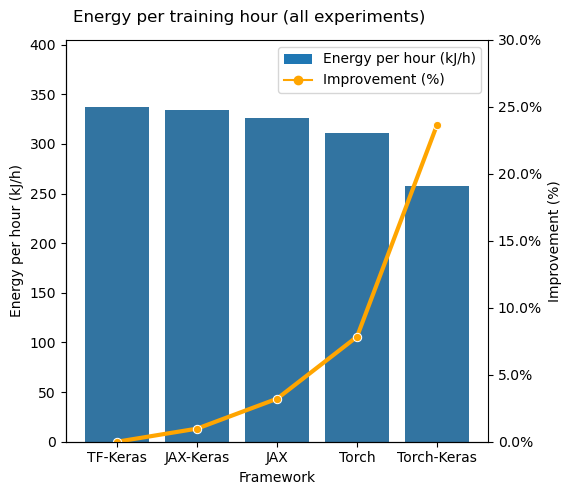

In [ ]:
base_df = add_labels(energy_sum_df)

plot = sns.catplot(
    data=base_df,
    x="backend",
    y="global_energy_per_hour",
    kind="bar",
    errorbar="sd",
    order=base_df["backend"]
)

ax = plot.ax
ax.set_ylabel("Energy per hour (kJ/h)")
ax.set_ylim(0, max_value * 1.2)

ax2 = ax.twinx()
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.set_ylabel("Improvement (%)")
ax2.set_ylim(0, 0.3)

sns.lineplot(
    data=base_df,
    x="backend",
    y="improvement",
    ax=ax2,
    marker="o",
    color="orange",
    linewidth=3
)

add_title(plot, "Energy per training hour (all experiments)", adjust=0.92)
plot.set_titles(col_template="{col_name}")
plot.set_axis_labels(titles["backend"], "Energy per hour (kJ/h)")


legend_elements = [
    Patch(label="Energy per hour (kJ/h)"),
    Line2D([0], [0], color="orange", marker="o", label="Improvement (%)"),
]

ax.legend(handles=legend_elements, loc="best")

#save_plot(plot, "energy_per_hour_all")


## Test results

In [68]:
df_list = []

for keys, subset_df in index_df[index_df["filename"] == "test"].groupby(experiment_config):
    backend, model, model_complexity, precision, seed = keys

    base_df = pd.read_csv(subset_df.iloc[0]["path"])

    base_df["backend"] = backend
    base_df["model_type"] = model
    base_df["model_complexity"] = model_complexity
    base_df["precision"] = precision
    base_df["seed"] = seed

    df_list.append(base_df)

test_df = pd.concat(df_list, ignore_index=True)
test_df = exp_config_category(test_df)

test_df = test_df[experiment_config + ["time", "loss", "metric"]]
test_df = test_df.sort_values(by=experiment_config).reset_index(drop=True)

test_df.head()

,backend,model_type,model_complexity,precision,seed,time,loss,metric
0,jax,mlp,simple,fp32,42,2.446716,0.282897,0.898985
1,jax,mlp,simple,fp32,43,2.461142,0.284469,0.900876
2,jax,mlp,simple,fp32,44,2.439721,0.287033,0.895999
3,jax,mlp,simple,fp16,42,3.424967,NaN,0.100717
4,jax,mlp,simple,fp16,43,3.440528,NaN,0.100717


In [69]:
failed_df: pd.DataFrame = (
    test_df.groupby(experiment_config)
    .apply(lambda g: g[["loss", "metric"]].isna().values.any())
    .reset_index(name="failed")
)

# Add experiments with errors
error_df["error"] = True

failed_df = failed_df.merge(
    error_df[experiment_config + ["error"]],
    on=experiment_config,
    how="outer"
)

failed_df["failed"] = failed_df["failed"].fillna(False)
failed_df["error"] = failed_df["error"].fillna(False)

failed_df.head()

/tmp/ipykernel_4024815/3708063559.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df.groupby(experiment_config)


,backend,model_type,model_complexity,precision,seed,failed,error
0,jax,cnn,complex,bf16,42,False,False
1,jax,cnn,complex,bf16,43,False,False
2,jax,cnn,complex,bf16,44,False,False
3,jax,cnn,complex,fp16,42,True,False
4,jax,cnn,complex,fp16,43,True,False


In [70]:
num_failed_df = (
    failed_df.groupby(["precision", "seed"])
    .apply(lambda g: pd.Series({
        "num_success": (~g["failed"] & ~g["error"]).sum(),
        "num_failed": g["failed"].sum(),
        "num_error": g["error"].sum()
    }))
    .reset_index()
)

num_failed_df["precision"] = pd.Categorical(
    num_failed_df["precision"],
    categories=orders["precision"],
    ordered=True
)
num_failed_df = num_failed_df.sort_values(by="precision")

num_failed_df.head()

/tmp/ipykernel_4024815/4105145371.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  failed_df.groupby(["precision", "seed"])


,precision,seed,num_success,num_failed,num_error
6,fp32,42,30,0,0
7,fp32,43,30,0,0
8,fp32,44,30,0,0
3,fp16,42,7,17,6
4,fp16,43,7,17,6


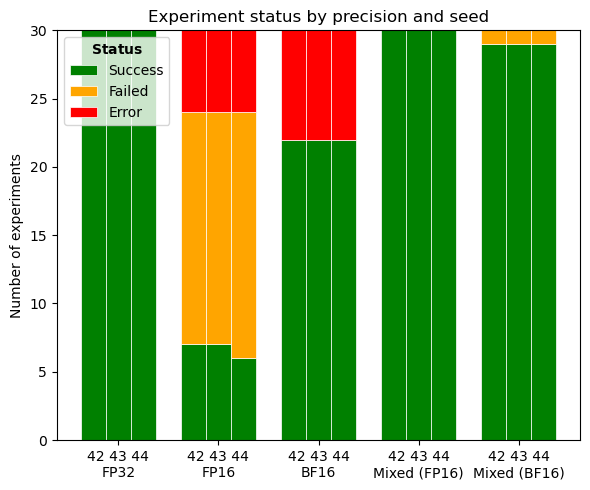

In [71]:
colors = {
    "num_success": "green",
    "num_failed":  "orange",
    "num_error":   "red"
}

formatted = np.arange(len(orders["precision"])) # base positions
bar_width = 0.25

fig, ax = plt.subplots(figsize=(6,5))

for i, seed in enumerate(orders["seed"]):
    subset = num_failed_df[num_failed_df["seed"] == seed]
    bottoms = np.zeros(len(subset))

    for col in colors.keys():
        ax.bar(
            formatted + i * bar_width, # Move each seed bars
            subset[col].values,
            bar_width,
            bottom=bottoms,
            color=colors[col],
            linewidth=0.5,
            edgecolor="white"
        )
        bottoms += subset[col].values


ax.set_xticks(formatted + bar_width)
precision_labels = labels["precision"]
ax.set_xticklabels([f"42 43 44\n{precision_labels[precision]}" for precision in orders["precision"]])

ax.set_ylabel("Number of experiments")

ax.set_title("Experiment status by precision and seed")
ax.legend(["Success","Failed","Error"], title=r"$\bf{Status}$", loc="upper left")

plt.tight_layout()
plt.show()

save_plot(fig, "status")

In [72]:
num_failed_df[["num_success", "num_failed", "num_error"]].sum()

num_success    353
num_failed      55
num_error       42
dtype: int64

In [73]:
test_metric_df = test_df.melt(
    id_vars=experiment_config,
    value_vars=["loss", "metric"],
    var_name="measure",
    value_name="value"
)
test_metric_df.head()

,backend,model_type,model_complexity,precision,seed,measure,value
0,jax,mlp,simple,fp32,42,loss,0.282897
1,jax,mlp,simple,fp32,43,loss,0.284469
2,jax,mlp,simple,fp32,44,loss,0.287033
3,jax,mlp,simple,fp16,42,loss,NaN
4,jax,mlp,simple,fp16,43,loss,NaN


In [74]:
def plot_test_results(df: pd.DataFrame, model: str, complexity: str, loss_name: str, metric_name: str, log=False):
    plot_df = df.query("model_type==@model and model_complexity==@complexity")
    plot_df = add_labels(plot_df)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    sns.barplot(
        data=plot_df.query("measure=='loss'"),
        x="backend",
        y="value",
        hue="precision",
        ax=axes[0]
    )

    axes[0].set_title(f"Loss ({loss_name})")
    axes[0].set_xlabel("Framework")
    axes[0].set_ylabel("Loss")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
    axes[0].legend_.remove()


    sns.barplot(
        data=plot_df.query("measure=='metric'"),
        x="backend",
        y="value",
        hue="precision",
        ax=axes[1]
    )

    axes[1].set_title(f"{metric_name}")
    axes[1].set_xlabel("Framework")
    axes[1].set_ylabel(f"{metric_name}")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
    axes[1].legend_.remove()

    # Legend
    handles, leg_labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        leg_labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1),
        ncol=len(leg_labels)
    )

    model = labels["model_type"][model]
    complexity = labels["model_complexity"][complexity]

    fig.suptitle(f"Test results ({model} - {complexity})", y=1.05)

    if log:
        for _, ax in enumerate(axes.flat):
            ax.set(yscale="log")
            ax.set_ylabel(ax.get_ylabel() + " (log)")

    plt.tight_layout()
    save_plot(fig, f"test_res_{model}_{complexity}")

    plt.show()

/tmp/ipykernel_4024815/3460516695.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_4024815/3460516695.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


<Figure size 640x480 with 0 Axes>

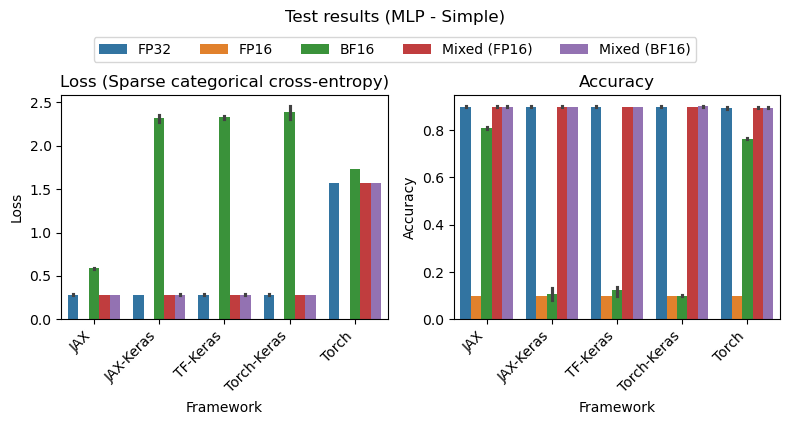

/tmp/ipykernel_4024815/3460516695.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_4024815/3460516695.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


<Figure size 640x480 with 0 Axes>

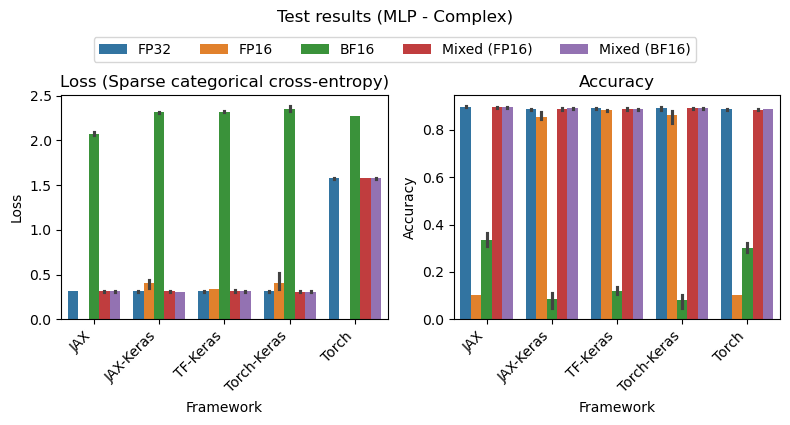

/tmp/ipykernel_4024815/3460516695.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_4024815/3460516695.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


<Figure size 640x480 with 0 Axes>

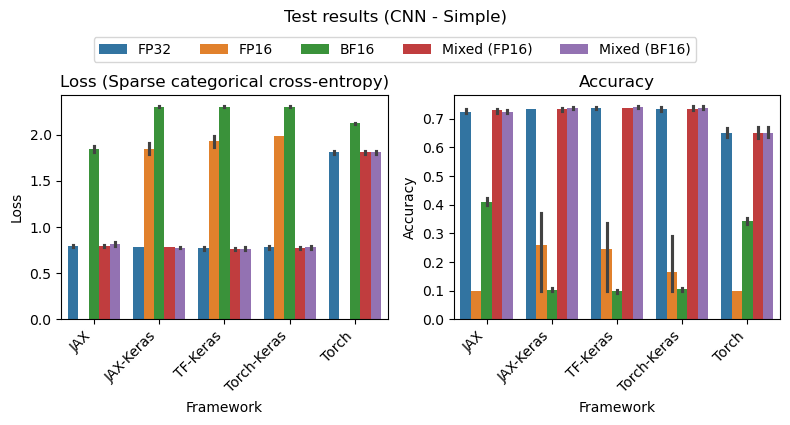

/tmp/ipykernel_4024815/3460516695.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_4024815/3460516695.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


<Figure size 640x480 with 0 Axes>

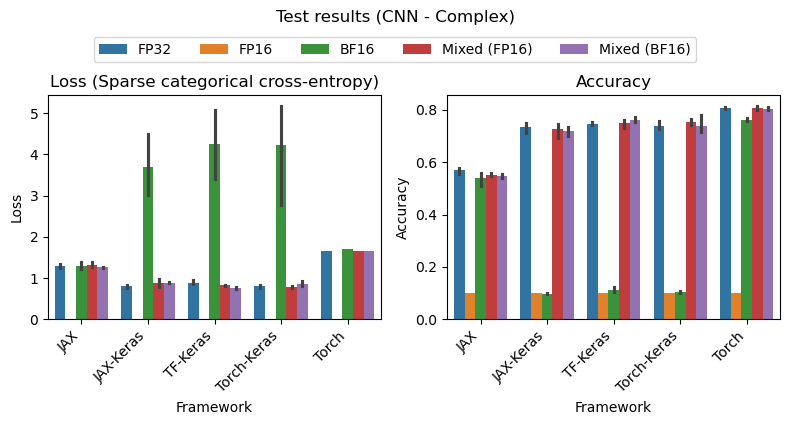

/tmp/ipykernel_4024815/3460516695.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_4024815/3460516695.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


<Figure size 640x480 with 0 Axes>

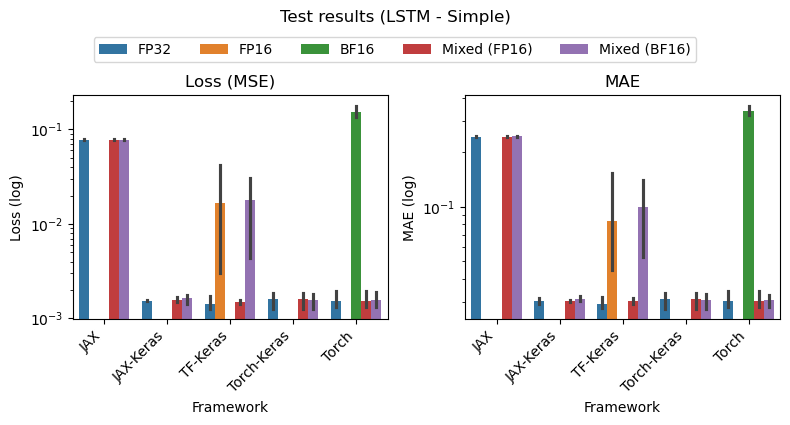

/tmp/ipykernel_4024815/3460516695.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_4024815/3460516695.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


<Figure size 640x480 with 0 Axes>

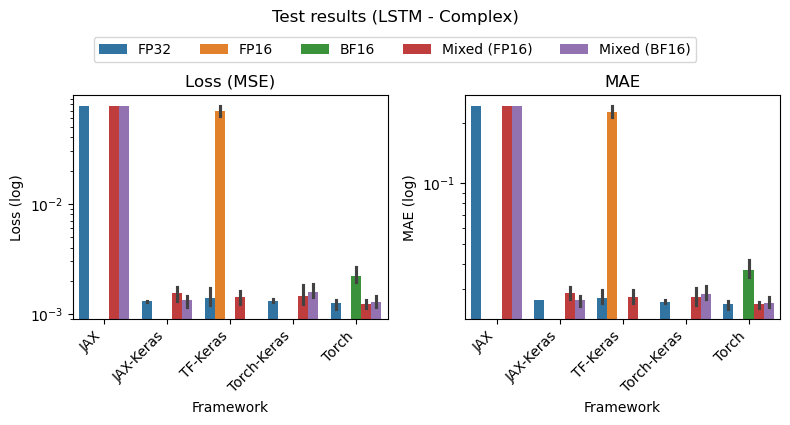

In [75]:
mapping = {
    "mlp": ("Sparse categorical cross-entropy", "Accuracy", False),
    "cnn": ("Sparse categorical cross-entropy", "Accuracy", False),
    "lstm": ("MSE", "MAE", True),
}

for model in orders["model_type"]:
    for complexity in orders["model_complexity"]:
        loss_name, metric_name, log = mapping[model]
        plt.figure()
        plot_test_results(test_metric_df, model, complexity, loss_name, metric_name, log)

In [76]:
base_df = test_df.query("model_type=='mlp' and model_complexity=='complex'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["loss"]
    .median()
    .reset_index()
)
ref = base_df["loss"].min()
base_df["comp"] = 1 - (base_df["loss"] / ref)
base_df = base_df.sort_values(by="loss", ascending=True)
base_df.head()

,backend,model_type,model_complexity,loss,comp
7,jax-keras,mlp,complex,0.318594,0.000000
1,jax,mlp,complex,0.318603,-0.000028
19,torch-keras,mlp,complex,0.319676,-0.003397
13,tf-keras,mlp,complex,0.321130,-0.007962
25,torch,mlp,complex,1.575224,-3.944301


## Summary

In [77]:
seed_variability = []

for metric in ["energy", "energy_per_hour"]:
    for (backend, model, model_complexity, precision), df in total_energy_df.groupby(experiment_config[:-1]):
        values = df.sort_values("seed")[metric].values
        
        mean = np.mean(values)
        std = np.std(values)

        seed_variability.append({
            "backend": backend,
            "model_type": model,
            "model_complexity": model_complexity,
            "precision": precision,
            "metric": metric,
            "mean": mean,
            "std": std
        })

energy_variability_df = pd.DataFrame(seed_variability)

In [83]:
metrics_cfg = {
        "training_time": {
            "label": "Training time (s)",
            "best": "min"
        },
        "testing_time": {
            "label": "Testing time (s)",
            "best": "min"
        },
        "train_gpu_utilization_mean": {
            "label": "Mean GPU usage (%)",
            "best": "max"
        },
        "energy": {
            "label": "Total energy (kJ)",
            "best": "min"
        },
        "energy_per_hour": {
            "label": "Energy per hour (kJ/h)",
            "best": "min"
        },
        "test_loss_mean": {
            "label": "Test loss",
            "best": "min"
        },
        "test_metric_mean": {
            "label": "Test metric",
            "best": "max"
        }
    }


In [84]:
summary_df = pd.concat(
    [variability_df[energy_variability_df.columns],
    energy_variability_df]
).reset_index(drop=True)

summary_df = summary_df[summary_df["metric"].isin(metrics_cfg.keys())]
summary_df.head()

,backend,model_type,model_complexity,precision,metric,mean,std
0,jax,cnn,complex,bf16,training_time,589.753131,2.819147
1,jax,cnn,complex,fp16,training_time,600.153922,12.271100
2,jax,cnn,complex,fp32,training_time,604.010209,4.338946
3,jax,cnn,complex,mixed_bf16,training_time,655.684403,21.230969
4,jax,cnn,complex,mixed_fp16,training_time,639.842714,1.395464


In [85]:
def format_cell(value: float, bold, underline) -> str:
    if pd.isna(value):
        return "--"
    
    formatted = f"{value:.2f}"

    if underline:
        formatted = f"\\underline{{{formatted}}}"
    
    if bold:
        formatted = f"\\textbf{{{formatted}}}"

    return formatted

In [86]:
label_map = {k: v["label"] for k, v in metrics_cfg.items()}
best_by_label = {v["label"]: v["best"] for v in metrics_cfg.values()}
ordered_labels = [v["label"] for v in metrics_cfg.values()]

def summary_table(df: pd.DataFrame, model: str, complexity: str):
    plot_df = df.query("model_type==@model and model_complexity==@complexity")
    plot_df = add_labels(plot_df)

    # Keep only relevant columns
    plot_df["metric"] = plot_df["metric"].map(label_map)
    plot_df["mean"] = plot_df["mean"].round(2)

    # Replace precision names
    plot_df["precision"] = (
        plot_df["precision"]
        .replace({
            "Mixed (FP16)": "Mixed-FP16",
            "Mixed (BF16)": "Mixed-BF16"
        })
    )

    # Create the table
    pivot_table = plot_df.pivot_table(
        index=["backend", "precision"],
        columns="metric",
        values="mean",
        aggfunc="first",
        sort=False
    )

    # Reorder columns
    pivot_table = pivot_table[label_map.values()]
    latex_table = pivot_table.copy()

    # Add bold and underline to best values
    for col in pivot_table.columns:
        best_type = best_by_label[col]
        col_vals: pd.Series = pivot_table[col]
        
        # Global best
        if best_type == "min":
            best_global_val = col_vals.min(skipna=True)
            is_best_global = np.isclose(col_vals, best_global_val, equal_nan=False)
        else:
            best_global_val = col_vals.max(skipna=True)
            is_best_global = np.isclose(col_vals, best_global_val, equal_nan=False)

        # Best by backend
        if best_type == "min":
            is_best_by_backend = col_vals.eq(
                col_vals.groupby(level="backend").transform("min")
            )
        else:
            is_best_by_backend = col_vals.eq(
                col_vals.groupby(level="backend").transform("max")
        )
            
        zipped_values = zip(col_vals.tolist(), is_best_global.tolist(), is_best_by_backend.tolist())

        latex_table[col] = [
            format_cell(value, bold, underline) for value, bold, underline in zipped_values
        ]

    # Rename index columns
    latex_table = latex_table.rename_axis(index=["Framework", "Precision"], columns="")

    # Caption
    model = labels["model_type"][model]
    caption = (
        f"Summary of results for {model} ({complexity}). "
        "The best overall values are shown in \\textbf{bold}, "
        "while the best values within each framework are \\underline{underlined}."
    )
    
    # Save to latex
    output_path = f"img/summary_table_{model}_{complexity}.tex"
    latex_table.to_latex(
        output_path,
        index=True,
        multirow=True,
        escape=False,
        caption=caption,
        label=f"tab:summary_{model}_{complexity}"
    )

    # Change \cline with empty lines
    with open(output_path, "r", encoding="utf-8") as f:
        content = f.read()

    content = re.sub(r"\\cline\{1-[0-9]+\}", "&  &  &  &  &  &  &  &  \\\\\\\\", content)

    with open(output_path, "w", encoding="utf-8") as f:
        f.write(content)

    return latex_table


In [87]:
summary_table(summary_df, "mlp", "simple")

Training time (s)  \
Framework   Precision                                 
JAX         FP32                             227.04   
            FP16                 \underline{226.40}   
            BF16                             229.42   
            Mixed-FP16                       289.86   
            Mixed-BF16                       290.17   
JAX-Keras   FP32                             136.45   
            FP16        \textbf{\underline{126.42}}   
            BF16                             132.75   
            Mixed-FP16                       153.79   
            Mixed-BF16                       148.43   
TF-Keras    FP32                             129.43   
            FP16                             131.74   
            BF16        \textbf{\underline{126.42}}   
            Mixed-FP16                       134.11   
            Mixed-BF16                       129.74   
Torch-Keras FP32                 \underline{474.48}   
            FP16                             504.84   
            BF16                             493.16   
            Mixed-FP16                       627.30   
            Mixed-BF16                       523.18   
Torch       FP32                             160.83   
            FP16                             164.50   
            BF16                 \underline{159.50}   
            Mixed-FP16                       197.54   
            Mixed-BF16                       194.86   

                                 Testing time (s)          Mean GPU usage (%)  \
Framework   Precision                                                           
JAX         FP32                 \underline{2.45}            \underline{5.18}   
            FP16                             3.11                        4.66   
            BF16                             2.77                        4.80   
            Mixed-FP16                       2.75                        5.11   
            Mixed-BF16                       3.10                        5.09   
JAX-Keras   FP32                             3.47                        9.74   
            FP16                 \underline{2.80}                        9.41   
            BF16                             3.44           \underline{10.37}   
            Mixed-FP16                       3.44                        9.04   
            Mixed-BF16                       3.44                        9.29   
TF-Keras    FP32                             3.43                        8.58   
            FP16                 \underline{2.44}                        9.92   
            BF16                             3.43                        9.23   
            Mixed-FP16                       3.43           \underline{11.33}   
            Mixed-BF16                       3.44                        9.00   
Torch-Keras FP32        \textbf{\underline{1.01}}           \underline{10.41}   
            FP16        \textbf{\underline{1.01}}                        9.19   
            BF16        \textbf{\underline{1.01}}                        9.33   
            Mixed-FP16  \textbf{\underline{1.01}}                        9.47   
            Mixed-BF16  \textbf{\underline{1.01}}                        9.28   
Torch       FP32        \textbf{\underline{1.01}}                       15.13   
            FP16        \textbf{\underline{1.01}}                       13.83   
            BF16        \textbf{\underline{1.01}}                       12.61   
            Mixed-FP16  \textbf{\underline{1.01}}                       15.33   
            Mixed-BF16  \textbf{\underline{1.01}}  \textbf{\underline{15.68}}   

                                Total energy (kJ)  \
Framework   Precision                               
JAX         FP32                            14.69   
            FP16                \underline{14.35}   
            BF16                            14.51   
            Mixed-FP16                      18.39   
            Mixed-BF16                    

In [88]:
comparison_df = summary_df.groupby(experiment_config[:-2] + ["metric"])["mean"].median().reset_index()
comparison_df.head()

,backend,model_type,model_complexity,metric,mean
0,jax,cnn,complex,energy,81.984663
1,jax,cnn,complex,energy_per_hour,461.275329
2,jax,cnn,complex,test_loss_mean,1.284735
3,jax,cnn,complex,test_metric_mean,0.843990
4,jax,cnn,complex,testing_time,3.374394


In [89]:
label_map = {k: v["label"] for k, v in metrics_cfg.items()}
best_by_label = {v["label"]: v["best"] for v in metrics_cfg.values()}
ordered_labels = [v["label"] for v in metrics_cfg.values()]

def comparison_summary_table(df: pd.DataFrame, model: str):
    plot_df = df.query("model_type==@model")
    plot_df = add_labels(plot_df)

    # Keep only relevant columns
    plot_df["metric"] = plot_df["metric"].map(label_map)
    plot_df["mean"] = plot_df["mean"].round(2)

    # Create the table
    pivot_table = plot_df.pivot_table(
        index=["backend", "model_complexity"],
        columns="metric",
        values="mean",
        aggfunc="first",
        sort=False
    )

    # Reorder columns
    pivot_table = pivot_table[label_map.values()]
    latex_table = pivot_table.copy()

    # Add bold and underline to best values
    for col in pivot_table.columns:
        best_type = best_by_label[col]
        col_vals: pd.Series = pivot_table[col]
        
        # Global best
        if best_type == "min":
            best_global_val = col_vals.min(skipna=True)
            is_best_global = np.isclose(col_vals, best_global_val, equal_nan=False)
        else:
            best_global_val = col_vals.max(skipna=True)
            is_best_global = np.isclose(col_vals, best_global_val, equal_nan=False)

        # Best by backend
        if best_type == "min":
            is_best_by_backend = col_vals.eq(
                col_vals.groupby(level="backend").transform("min")
            )
        else:
            is_best_by_backend = col_vals.eq(
                col_vals.groupby(level="backend").transform("max")
        )
            
        zipped_values = zip(col_vals.tolist(), is_best_global.tolist(), is_best_by_backend.tolist())

        latex_table[col] = [
            format_cell(value, bold, underline) for value, bold, underline in zipped_values
        ]

    # Rename index columns
    latex_table = latex_table.rename_axis(index=["Framework", "Version"], columns="")

    # Caption
    model = labels["model_type"][model]
    caption = (
        f"Comparison of results for both {model} versions. "
        "The best overall values are shown in \\textbf{bold}, "
        "while the best values within each framework are \\underline{underlined}."
    )
    
    # Save to latex
    output_path = f"img/comparison_table_{model}.tex"
    latex_table.to_latex(
        output_path,
        index=True,
        multirow=True,
        escape=False,
        caption=caption,
        label=f"tab:comparison_{model}"
    )

    # Change \cline with empty lines
    with open(output_path, "r", encoding="utf-8") as f:
        content = f.read()

    content = re.sub(r"\\cline\{1-[0-9]+\}", "&  &  &  &  &  &  &  &  \\\\\\\\", content)

    with open(output_path, "w", encoding="utf-8") as f:
        f.write(content)

    return latex_table


In [90]:
comparison_summary_table(comparison_df, "mlp")

Training time (s)           Testing time (s)  \
Framework   Version                                                           
JAX         Complex                       462.47                       4.46   
            Simple            \underline{229.42}           \underline{2.77}   
JAX-Keras   Complex                       179.84                       5.43   
            Simple            \underline{136.45}           \underline{3.44}   
TF-Keras    Complex                       173.76                       6.39   
            Simple   \textbf{\underline{129.74}}           \underline{3.43}   
Torch       Complex                       321.67  \textbf{\underline{1.01}}   
            Simple            \underline{164.50}  \textbf{\underline{1.01}}   
Torch-Keras Complex                       851.26                       2.01   
            Simple            \underline{504.84}  \textbf{\underline{1.01}}   

                             Mean GPU usage (%)          Total energy (kJ)  \
Framework   Version                                                          
JAX         Complex            \underline{7.74}                      31.31   
            Simple                         5.09          \underline{14.69}   
JAX-Keras   Complex           \underline{17.42}                      13.31   
            Simple                         9.41           \underline{8.87}   
TF-Keras    Complex           \underline{17.41}                      13.01   
            Simple                         9.23  \textbf{\underline{8.23}}   
Torch       Complex  \textbf{\underline{17.64}}                      24.45   
            Simple                        15.13          \underline{10.76}   
Torch-Keras Complex           \underline{10.79}                      58.60   
            Simple                         9.33          \underline{32.59}   

                          Energy per hour (kJ/h)                  Test loss  \
Framework   Version                                                           
JAX         Complex                       243.07                       0.32   
            Simple            \underline{228.44}  \textbf{\underline{0.28}}   
JAX-Keras   Complex                       261.38                       0.31   
            Simple   \textbf{\underline{228.37}}  \textbf{\underline{0.28}}   
TF-Keras    Complex                       264.78                       0.32   
            Simple            \underline{228.55}  \textbf{\underline{0.28}}   
Torch       Complex                       260.30           \underline{1.57}   
            Simple            \underline{235.50}           \underline{1.57}   
Torch-Keras Complex                       248.55                       0.31   
            Simple            \underline{233.51}  \textbf{\underline{0.28}}   

                                   Test metric  
Framework   Version                             
JAX         Complex                       0.91  
            Simple            \underline{0.92}  
JAX-Keras   Complex  \textbf{\underline{0.98}}  
            Simple                        0.92  
TF-Keras    Complex  \textbf{\underline{0.98}}  
            Simple                        0.92  
Torch       Complex                       0.86  
            Simple            \underline{0.89}  
Torch-Keras Complex  \textbf{\underline{0.98}}  
            Simple                        0.92

# Comparison

## Correlation

In [91]:
total_energy_df.head()

,backend,model_type,model_complexity,precision,seed,energy,training_time,energy_per_hour
0,jax,mlp,simple,fp32,42,13.898514,218.031574,229.483503
1,jax,mlp,simple,fp32,43,15.192393,234.050772,233.678420
2,jax,mlp,simple,fp32,44,14.993291,229.041067,235.660130
3,jax,mlp,simple,fp16,42,13.783159,217.017115,228.642664
4,jax,mlp,simple,fp16,43,14.588840,231.114597,227.245804


In [92]:
# Remove error experiments
base_df = total_energy_df[~total_energy_df["training_time"].isna()].copy()
base_df = base_df.sort_values(by=["model_type"])

results = []

for keys, group in base_df.groupby(["model_type"]):
    
    corr = group["training_time"].corr(group["energy"])

    X = group[["training_time"]].values
    y = group["energy"].values

    modelo = LinearRegression().fit(X, y)

    slope_w = modelo.coef_[0] * 1000 # kJ/s -> J/s = W
    intercept = modelo.intercept_
    r2 = modelo.score(X, y)

    results.append({
        "model_type": keys[0],
        "correlation": corr,
        "mean_power_W": slope_w,
        "intercept_kJ": intercept,
        "R2": r2
    })

results_df = pd.DataFrame(results)

results_df.round(5).head()

,model_type,correlation,mean_power_W,intercept_kJ,R2
0,mlp,0.99718,68.37403,-0.13637,0.99438
1,cnn,0.98713,74.76043,9.44365,0.97442
2,lstm,0.99596,69.47304,8.16180,0.99194


## Comparison plots

### Model versions comparison

In [93]:
summary_df.head()

,backend,model_type,model_complexity,precision,metric,mean,std
0,jax,cnn,complex,bf16,training_time,589.753131,2.819147
1,jax,cnn,complex,fp16,training_time,600.153922,12.271100
2,jax,cnn,complex,fp32,training_time,604.010209,4.338946
3,jax,cnn,complex,mixed_bf16,training_time,655.684403,21.230969
4,jax,cnn,complex,mixed_fp16,training_time,639.842714,1.395464


In [94]:
complex_comp_df = summary_df.pivot_table(
    index=["model_type", "backend", "precision", "metric"],
    columns="model_complexity",
    values="mean"
).reset_index()

complex_comp_df["comp"] = (complex_comp_df["complex"] / complex_comp_df["simple"]) - 1

complex_comp_df.head()

model_complexity,model_type,backend,precision,metric,complex,simple,comp
0,cnn,jax,bf16,energy,78.868792,18.270577,3.316711
1,cnn,jax,bf16,energy_per_hour,481.469037,244.701923,0.967574
2,cnn,jax,bf16,test_loss_mean,1.283854,1.848958,-0.305634
3,cnn,jax,bf16,test_metric_mean,0.781196,0.368074,1.122384
4,cnn,jax,bf16,testing_time,3.373953,2.430110,0.388395


In [95]:
def plot_version_increments(df: pd.DataFrame, model: str):
    plot_df = df.query("model_type==@model")
    plot_df = plot_df.groupby(["backend", "metric"])["comp"].median().mul(100).reset_index()

    plot_df = add_labels(plot_df)

    # Remove units from labels
    clean_labels = {
        key: re.sub(r'\s*\(.*?\)', '', value).strip()
        for key, value in label_map.items()
    }
    plot_df["metric"] = plot_df["metric"].map(clean_labels)

    plot = sns.catplot(
        data=plot_df,
        x="metric",
        y="comp",
        kind="bar",
        hue="backend",
        order=clean_labels.values()
    )

    model = labels["model_type"][model]

    add_title(plot, f"Metric increments of {model} complex over simple version")
    plot._legend.set_title(r"$\bf{Framework}$")
    plot._legend.set_loc("upper right")
    plot._legend.set_bbox_to_anchor((0.98, 0.93))

    plot.set_axis_labels("Metric", "Increment (%)")
    plot.set_xticklabels(clean_labels.values(), rotation=45, ha="right")

    plt.tight_layout()
    save_plot(plot, f"version_increments_{model}", format="pdf")

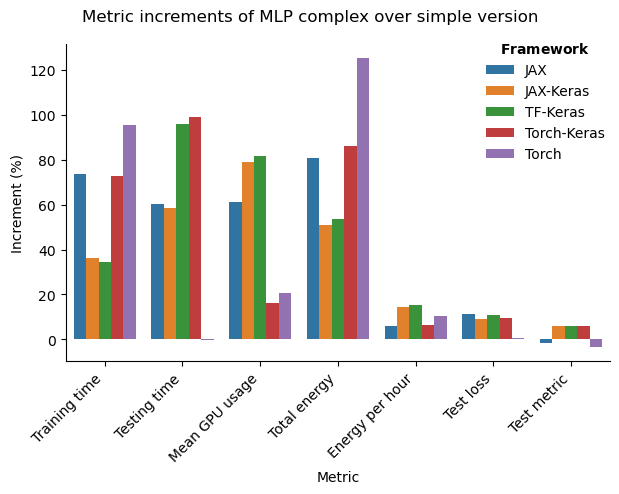

In [96]:
plot_version_increments(complex_comp_df, "mlp")

In [97]:
# Normalize metrics
# Plot area plots for each framework => more area is better

def normalize_metric(values: pd.Series):
    # Normalize to [0, 1]
    normalized = values / values.max()
    
    return normalized

In [98]:
model = "mlp"

plot_df = comparison_df.query("model_type==@model").copy()

plot_df["mean_norm"] = (
    plot_df.groupby(["metric"])["mean"]
    .transform(lambda values: normalize_metric(values))
)

plot_df = add_labels(plot_df)
plot_df["metric"] = plot_df["metric"].map(label_map)

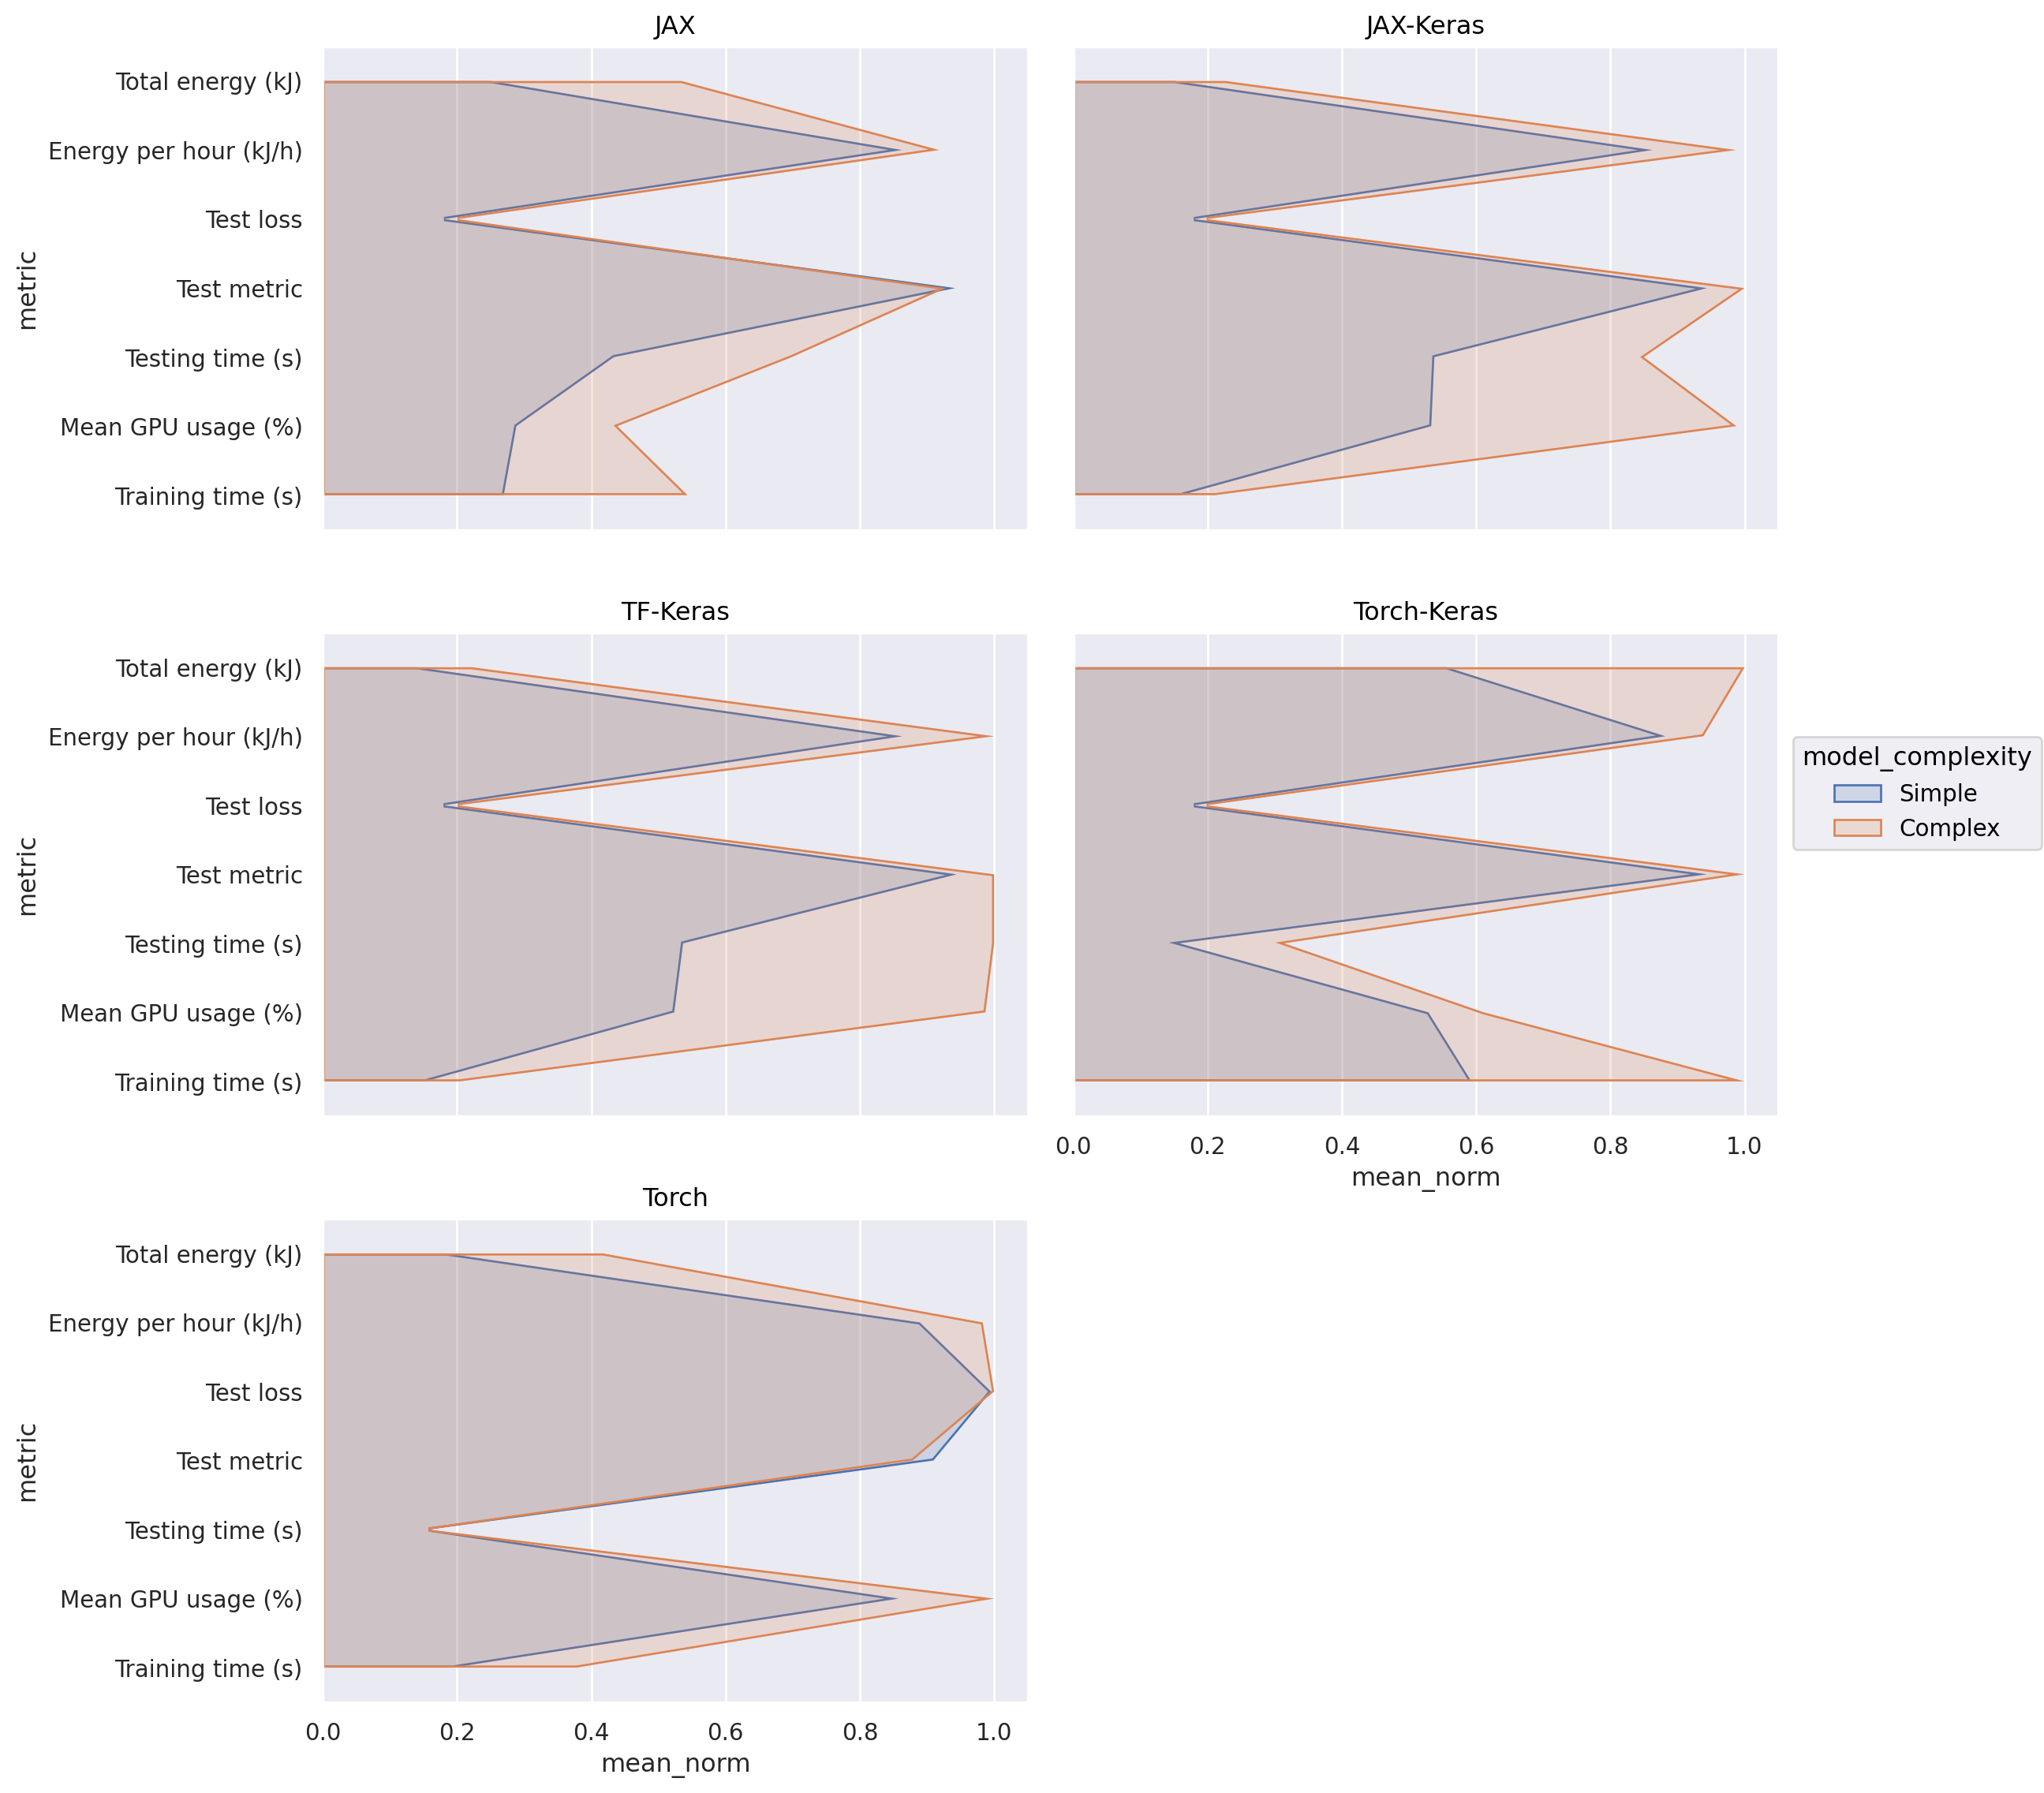

In [99]:
(
    so.Plot(plot_df, y="metric", x="mean_norm", color="model_complexity")
        .facet("backend", wrap=2)
        .add(so.Area())
        .layout(size=(12, 12))
)


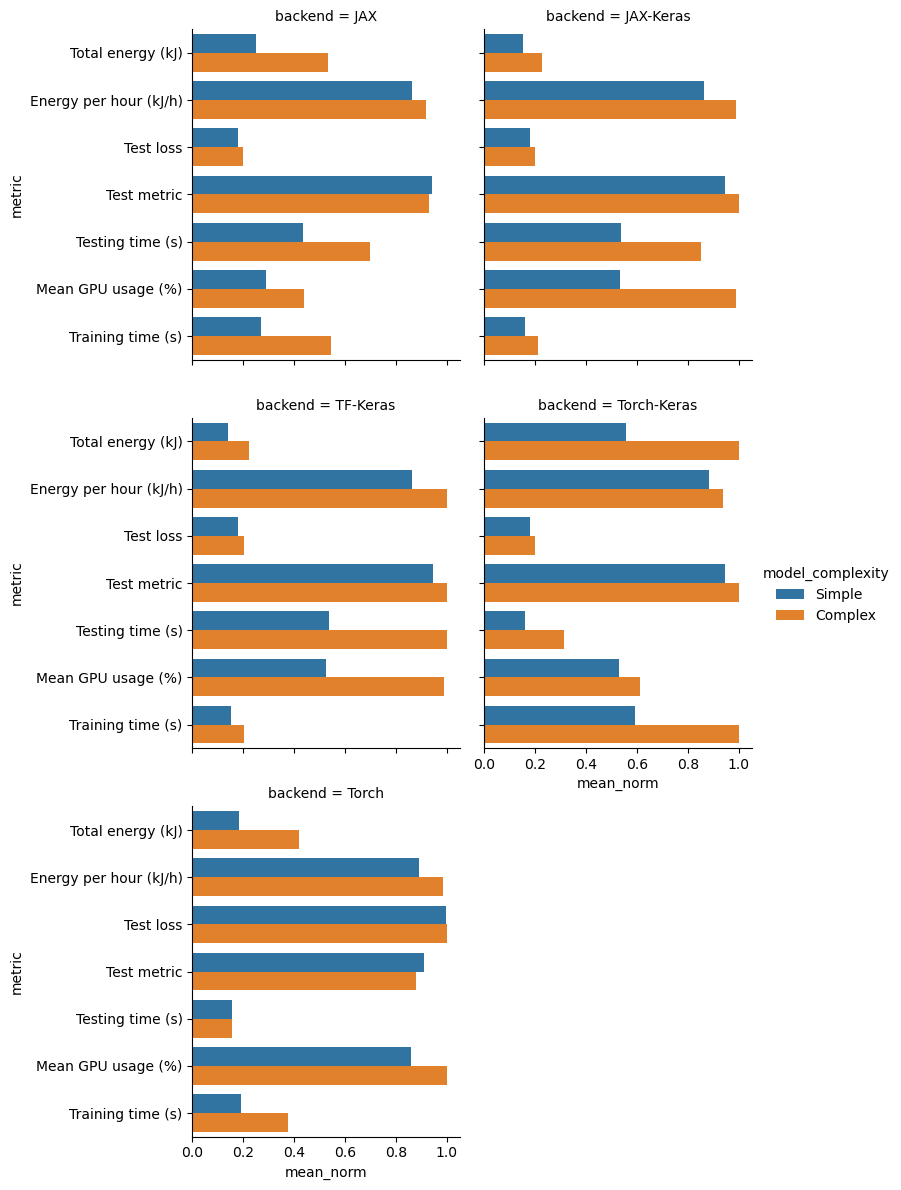

In [100]:
sns.catplot(
    data=plot_df,
    x="mean_norm",
    y="metric",
    hue="model_complexity",
    col="backend",
    col_wrap=2,
    kind="bar",
    height=4,
    aspect=1
)

In [101]:
model = "mlp"

plot_df = comparison_df.query("model_type==@model and model_complexity=='complex'").copy()

plot_df["mean_norm"] = (
    plot_df.groupby(["metric"])["mean"]
    .transform(lambda values: normalize_metric(values))
)

plot_df = add_labels(plot_df)
plot_df["metric"] = plot_df["metric"].map(label_map)

In [102]:
plot_df.head()

,backend,model_type,model_complexity,metric,mean,mean_norm
28,JAX,MLP,Complex,Total energy (kJ),31.308947,0.534300
29,JAX,MLP,Complex,Energy per hour (kJ/h),243.074371,0.918027
30,JAX,MLP,Complex,Test loss,0.316543,0.200992
31,JAX,MLP,Complex,Test metric,0.908529,0.928282
32,JAX,MLP,Complex,Testing time (s),4.463553,0.698593


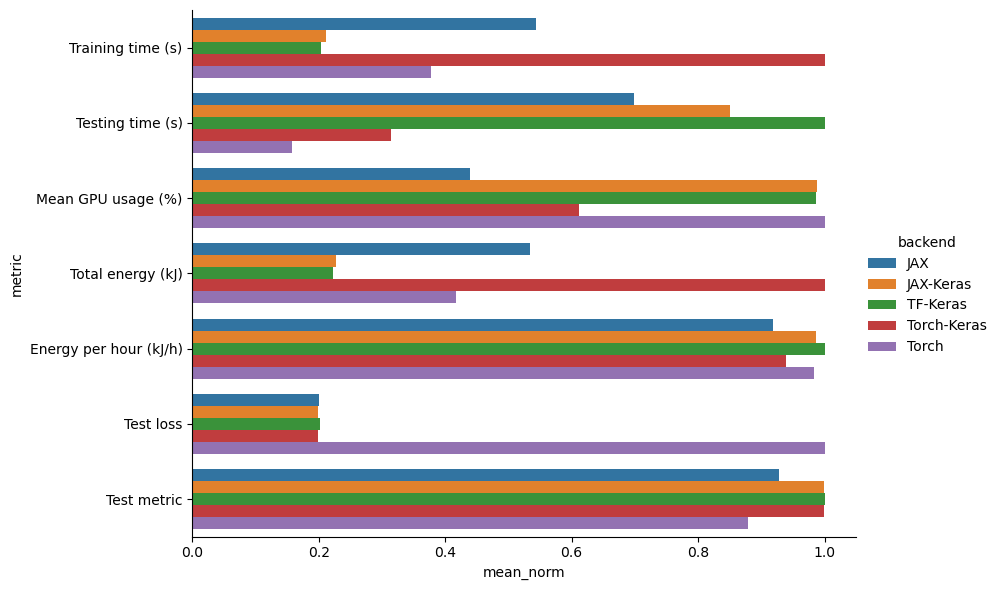

In [103]:
sns.catplot(
    data=plot_df,
    x="mean_norm",
    y="metric",
    hue="backend",
    kind="bar",
    aspect=1.5,
    height=6,
    order=ordered_labels
)

## Vs. plots

In [104]:
# Keep only successful experiments with all seeds
success_df = failed_df[~failed_df["failed"] & ~failed_df["error"]]
mask = (
    success_df.groupby(experiment_config[:-1])["seed"]
    .transform(lambda g: g.count() == 3)
)
success_df = success_df[mask][experiment_config].drop_duplicates()
success_df.head()

,backend,model_type,model_complexity,precision,seed
0,jax,cnn,complex,bf16,42
1,jax,cnn,complex,bf16,43
2,jax,cnn,complex,bf16,44
6,jax,cnn,complex,fp32,42
7,jax,cnn,complex,fp32,43


In [105]:
# Add training_time and max_memory
mixed_df = time_df.merge(
    memory_df,
    on="backend",
    how="left"
)

# Add mean GPU usage
mixed_df = mixed_df.merge(
    train_samples_df.groupby(experiment_config)["gpu_2_utilization"].mean().reset_index(name="train_gpu_utilization_mean"),
    on=experiment_config,
    how="left"
)

# Add energy and energy per hour
mixed_df = mixed_df.merge(
    total_energy_df[experiment_config + ["energy_per_hour", "energy"]],
    on=experiment_config,
    how="left"
)

# Add loss and metric
mixed_df = mixed_df.merge(
    test_df,
    on=experiment_config,
    how="left"
)

# Remove unsuccessful experiments
mixed_df = mixed_df.merge(
    success_df,
    on=experiment_config,
    how="inner"
)

mixed_df = (
    mixed_df.groupby(experiment_config[:-1])[["training_time", "max_memory", "train_gpu_utilization_mean", "energy_per_hour", "energy", "loss", "metric"]]
    .mean()
    .reset_index()
)

mixed_df.head()

,backend,model_type,model_complexity,precision,training_time,max_memory,train_gpu_utilization_mean,energy_per_hour,energy,loss,metric
0,jax,cnn,complex,bf16,589.753131,60.712097,69.170419,481.469037,78.868792,1.283854,0.538250
1,jax,cnn,complex,fp32,604.010209,60.712097,69.692120,538.756512,90.395882,1.285616,0.568305
2,jax,cnn,complex,mixed_bf16,655.684403,60.712097,66.809380,455.138893,82.841052,1.257812,0.547107
3,jax,cnn,complex,mixed_fp16,639.842714,60.712097,68.123225,461.275329,81.984663,1.320638,0.550226
4,jax,cnn,simple,bf16,268.779803,60.712097,10.475215,244.701923,18.270577,1.848958,0.409468


In [106]:
# Remove experiments with bad results (loss higher than median)
mask = mixed_df.groupby("model_type")["loss"].transform("median")
filtered_df = mixed_df[mixed_df["loss"] <= mask]
len(filtered_df)

59

In [107]:
# No half precision experiment remains
filtered_df.query("precision==['fp16', 'bf16']").head()

,backend,model_type,model_complexity,precision,training_time,max_memory,train_gpu_utilization_mean,energy_per_hour,energy,loss,metric


In [108]:
markers = ["o", "X", "P", "^", "v"]
precision_markers = {precision_labels[precision]: marker for precision, marker in zip(orders["precision"], markers)}
precision_markers

{'FP32': 'o',
 'FP16': 'X',
 'BF16': 'P',
 'Mixed (FP16)': '^',
 'Mixed (BF16)': 'v'}

In [109]:
metrics_cfg["max_memory"] = {
    "label": "Max GPU memory (GB)",
    "best": "min"
}

In [110]:
def get_pareto_df(df, metric_x, metric_y, improvement=0.01): # Minimum 1% improvement
    cfg_best_x = metrics_cfg[metric_x]["best"]
    cfg_best_y = metrics_cfg[metric_y]["best"]

    # Sort values by config
    df2 = df[[metric_x, metric_y]].sort_values(
        [metric_x, metric_y],
        ascending=[
            cfg_best_x=="min",
            cfg_best_y=="min"
        ]).reset_index(drop=True)
    
    # Prepare vars depending on best type
    if cfg_best_y == "min":
        best_y = np.inf
        threshold = 1 - improvement
    else:
        best_y = -np.inf
        threshold = 1 + improvement

    # Obtain pareto points
    points = []
    for _, row in df2.iterrows():
        is_best = (row[metric_y] < best_y * threshold) if cfg_best_y == "min" else (row[metric_y] > best_y * threshold)

        if is_best:
            points.append((row[metric_x], row[metric_y]))
            best_y = row[metric_y]

    pareto_df = pd.merge(
        df,
        pd.DataFrame(points, columns=[metric_x, metric_y]),
        on=[metric_x, metric_y]
    )

    return pareto_df

# Test pareto
df = pd.DataFrame([(1,3,'a'),(0,1,'b'),(1,2,'c'),(2,5,'d'),(3,2,'e'),(4,1,'f')], columns=['training_time','train_gpu_utilization_mean','filler'])
df = get_pareto_df(df, 'training_time', 'train_gpu_utilization_mean')
df.head()

,training_time,train_gpu_utilization_mean,filler
0,1,3,a
1,0,1,b
2,2,5,d


In [119]:
pareto_color = sns.color_palette("deep")[5]

In [200]:
def make_legend(plot):
    
    backend_handles = []
    precision_handles = []

    colors = sns.color_palette(n_colors=5)
    for backend, color in zip(orders["backend"], colors):
        label = labels["backend"][backend]
        backend_handles.append(Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))

    for precision in orders["precision"]:
        if (precision in ["fp16", "bf16"]): # There are no experiments with these
            continue
        label = labels["precision"][precision]
        marker = precision_markers[label]
        precision_handles.append(Line2D([0], [0], marker=marker, color='black', linestyle='None', label=label, markersize=10))


    ax = plot.axes.flat[0]

    # Backend legend
    title = titles["backend"]
    legend1 = ax.legend(handles=backend_handles, title=rf"$\bf{{ {title} }}$", loc="upper left", bbox_to_anchor=(1.05, 1))
    ax.add_artist(legend1)

    # Precision legend
    title = titles["precision"]
    legend2 = ax.legend(handles=precision_handles, title=rf"$\bf{{ {title} }}$", loc="upper left", bbox_to_anchor=(1.05, 0.6))

In [201]:
def plot_versus(df, model, complexity, metric_x, metric_y, log_x=False, log_y=False):
    df = df.query("model_type == @model and model_complexity == @complexity")

    plot = sns.relplot(
        data=add_labels(df),
        x=metric_x,
        y=metric_y,
        hue="backend",
        style="precision",
        markers=precision_markers,
        legend=False
    )
    
    ax = plot.axes.flat[0]

    # Labels
    model = labels["model_type"][model]
    complexity = labels["model_complexity"][complexity]
    metric_x_label = metrics_cfg[metric_x]["label"].split(" (")[0]
    metric_y_label = metrics_cfg[metric_y]["label"].split(" (")[0]

    add_title(plot, f"{metric_x_label} vs. {metric_y_label} ({model} - {complexity})", 0.92)

    # Set log scales
    axis_x_label = metrics_cfg[metric_x]["label"]
    axis_y_label = metrics_cfg[metric_y]["label"]

    if log_x:
        ax.set(xscale="log")
        axis_x_label = axis_x_label[:-1] + ", log)"
    
    if log_y:
        ax.set(yscale="log")
        axis_y_label = axis_y_label[:-1] + ", log)"

    plot.set_axis_labels(axis_x_label, axis_y_label)

    # Grid
    ax.grid(True, ls=":", alpha=.4)

    make_legend(plot)

    
    # Pareto frontier
    pareto_df = get_pareto_df(df, metric_x, metric_y)
    pareto_df = add_labels(pareto_df)

    sns.scatterplot(
        data=pareto_df,
        x=metric_x,
        y=metric_y,
        hue="backend",
        style="precision",
        markers=precision_markers,
        legend=False,
        ax=ax,
        
        edgecolor=pareto_color,
        linewidth=1,
        zorder=5
    )

    sns.lineplot(
        data=pareto_df,
        x=metric_x,
        y=metric_y,
        legend=False,
        ax=ax,
        
        color=pareto_color,
        zorder=-1
    )

    texts = []
    for _, row in pareto_df.iterrows():
        texts.append(
            ax.text(
                row[metric_x],
                row[metric_y],
                f"{row.backend}/{row.precision}",
                fontsize=9
            )
        )
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="->", lw=1))
    
    save_plot(plot, f"vs_{metric_x}_{metric_y}_{model}_{complexity}", format="pdf")

In [202]:
metrics_cfg.keys()

dict_keys(['training_time', 'testing_time', 'train_gpu_utilization_mean', 'energy', 'energy_per_hour', 'test_loss_mean', 'test_metric_mean', 'max_memory'])

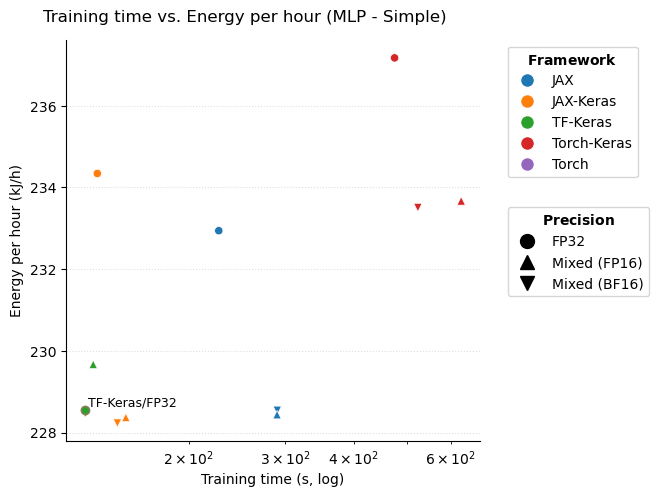

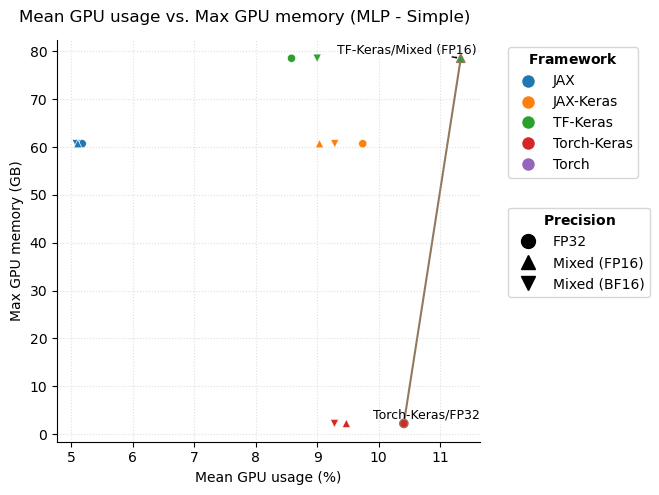

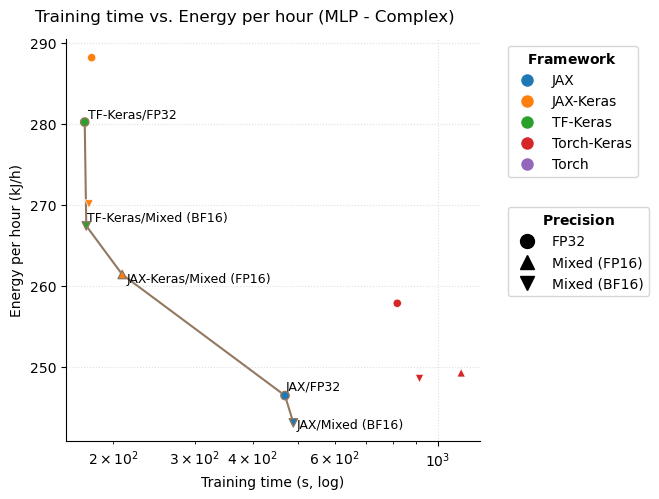

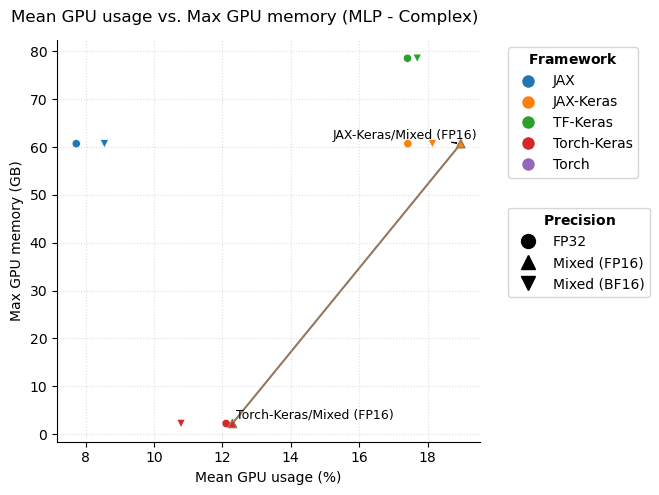

In [203]:
model = "mlp"
for complexity in orders["model_complexity"]:
    plot_versus(filtered_df, model, complexity, "training_time", "energy_per_hour", log_x=True, log_y=False)
    plot_versus(filtered_df, model, complexity, "train_gpu_utilization_mean", "max_memory")